# Section 1: Wiki relation


Selection of Nasdaq US stocks for Mega (>$200B); Large ($10B-$200B); Medium ($2B-$10B); Small ($300M-$2B) https://www.nasdaq.com/market-activity/stocks/screener?page=1&rows_per_page=25

In [ ]:
# !nvidia-smi  # this should display information about available GPUs
# %load_ext cudf.pandas

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import yfinance as yf
from concurrent.futures import ThreadPoolExecutor, as_completed
import time
import numpy as np
import pickle
import requests

Mounted at /content/drive


In [ ]:
!pip install python-dotenv
from dotenv import load_dotenv
import os

path = "/content/drive/MyDrive/Colab Notebooks/GNN/env"
load_dotenv(path)

# Access the loaded variables
API_KEY = os.getenv('FMP_API_KEY')

In [ ]:
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)
pd.set_option('display.max_rows', None)


In [ ]:
# Load the CSV containing Nasdaq tickers
nasdaq_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/GNN/nasdaq_screener_1731220264825.csv')
nasdaq_tickers = set(nasdaq_df['Symbol'])  # Adjust to your CSV's column name
len(nasdaq_tickers)

1456

The query was taken from "https://query.wikidata.org/", downloaded then saved as Json file.

In [ ]:
import json
import pandas as pd

# Define the paths to your JSON files
json_file_paths = ["/content/drive/MyDrive/Colab Notebooks/GNN/query3.json"]


# Store DataFrames in a dictionary
dataframes = {}

# Iterate through each file and load into a DataFrame
for i, file in enumerate(json_file_paths):
    with open(file, "r", encoding="utf-8") as f:
        data = json.load(f)  # Load the JSON file
        dataframes[f"df{i}"] = pd.DataFrame(data)  # Store DataFrame with a dynamic key



In [ ]:
print(dataframes["df0"].columns)
df0 = dataframes["df0"][dataframes["df0"]['ticker'].isin(nasdaq_tickers)]
print("No of unique Nasdaq company from Wiki Data", len(dataframes["df0"]['ticker'].unique()))
nasdaq_wiki_df = df0
print("No of unique Large/Mediu/Small companies in US Nasdaq with any relationship info from Wiki Data", len(nasdaq_wiki_df['ticker'].unique()))

Index(['id', 'idLabel', 'ticker', 'industryLabel', 'legalformLabel', 'followsTicker',
       'founded_byLabel', 'subsidiaryTicker', 'parentTicker', 'prod_mat_producedLabel',
       'ownedByTicker', 'ownerOfTicker', 'complies_withLabel'],
      dtype='object')
No of unique Nasdaq company from Wiki Data 1702
No of unique Large/Mediu/Small companies in US Nasdaq with any relationship info from Wiki Data 579


In [ ]:
nasdaq_wiki_index = nasdaq_wiki_df[['ticker']].drop_duplicates().sort_values('ticker').set_index('ticker')

nasdaq_wiki_index.index # Create the lookup table
lookup_table = nasdaq_wiki_df[['ticker']].drop_duplicates().sort_values('ticker').reset_index(drop=True)
lookup_table['index'] = lookup_table.index

# Convert to a dictionary for fast lookup
lookup_dict = lookup_table.set_index('ticker')['index'].to_dict()

print(lookup_dict)
print(len(lookup_dict))
print(lookup_table)

{'AAL': 0, 'AAON': 1, 'AAPL': 2, 'ABNB': 3, 'ACAD': 4, 'ACHC': 5, 'ACIW': 6, 'ACLS': 7, 'ACTG': 8, 'ADBE': 9, 'ADI': 10, 'ADP': 11, 'ADPT': 12, 'ADSK': 13, 'ADTN': 14, 'AEIS': 15, 'AGIO': 16, 'AGYS': 17, 'AKAM': 18, 'ALGN': 19, 'ALGT': 20, 'ALNY': 21, 'ALRM': 22, 'ALTI': 23, 'ALTR': 24, 'AMAT': 25, 'AMBA': 26, 'AMCX': 27, 'AMED': 28, 'AMGN': 29, 'AMKR': 30, 'AMLX': 31, 'AMSC': 32, 'AMWD': 33, 'AMZN': 34, 'ANDE': 35, 'ANGI': 36, 'ANSS': 37, 'APEI': 38, 'APPF': 39, 'APPN': 40, 'ARCB': 41, 'ARCC': 42, 'AROW': 43, 'ARWR': 44, 'ASTS': 45, 'ATNI': 46, 'ATSG': 47, 'AUR': 48, 'AVAV': 49, 'AVT': 50, 'AXON': 51, 'AZTA': 52, 'BAND': 53, 'BANF': 54, 'BCRX': 55, 'BEAM': 56, 'BECN': 57, 'BFC': 58, 'BHF': 59, 'BIIB': 60, 'BJRI': 61, 'BKNG': 62, 'BL': 63, 'BLKB': 64, 'BLMN': 65, 'BMBL': 66, 'BMRN': 67, 'BOKF': 68, 'BPOP': 69, 'BRKR': 70, 'BRY': 71, 'BSRR': 72, 'BSY': 73, 'BUSE': 74, 'BYND': 75, 'CACC': 76, 'CAKE': 77, 'CALM': 78, 'CAR': 79, 'CARG': 80, 'CART': 81, 'CASH': 82, 'CASY': 83, 'CATY': 84, '

# Section 2: To obtain the fundamental, technical and price data from FMP API

To fetch all the Mega, Large, Medium and Small dataset from Yahoo Finance API. Using Thread Pool Executor to Parallelize. (Data shorter than 5 years will be dropped)

To call the price data and ensure that we have the final group of ticker (With at least 5 years of data)

In [ ]:
import time
import requests
import pandas as pd
from datetime import datetime, timedelta

# Time between API calls (in seconds) to respect the 300 calls per minute limit
time_per_call = 60 / 300  # 0.2 seconds between each call

# Retry function to fetch data
def fetch_data_with_retries(url, retries=5, delay=5):
    attempt = 0
    while attempt < retries:
        try:
            response = requests.get(url)
            if response.status_code == 200:
                return response.json()  # Return the response in JSON format
            else:
                print(f"Error fetching data: {response.status_code}, attempt {attempt + 1}")
        except requests.exceptions.RequestException as e:
            print(f"Request failed: {e}, attempt {attempt + 1}")

        attempt += 1
        print(f"Retrying in {delay} seconds...")
        time.sleep(delay)  # Wait before retrying
    return None  # Return None if all retries fail

# Function for CPU-bound processing (e.g., data transformation)
def process_data_locally(data):
    # Simulate CPU-bound task: some heavy processing
    # You can add data processing steps here that you want to offload to the thread pool
    return data.sort_index()

# Function to fetch market data
def fetch_market_data(ticker):
    url = f"https://financialmodelingprep.com/api/v3/historical-price-full/{ticker}?apikey={API_KEY}"
    data = fetch_data_with_retries(url)
    if data and 'historical' in data:
        market_data = pd.DataFrame(data['historical'])
        market_data['date'] = pd.to_datetime(market_data['date'])
        market_data.set_index('date', inplace=True)

        # Filter data to last 5 years
        five_years_ago = datetime.today() - timedelta(days=6*365)
        market_data = market_data[market_data.index >= five_years_ago]

        # Process the data locally (sort data)
        processed_data = process_data_locally(market_data)

        return ticker, processed_data
    return ticker, None

# Function to fetch fundamental data (income and balance sheet data)
def fetch_fundamental_data(ticker):
    url_income = f"https://financialmodelingprep.com/api/v3/income-statement/{ticker}?apikey={API_KEY}&period=quarter"
    url_balance = f"https://financialmodelingprep.com/api/v3/balance-sheet-statement/{ticker}?apikey={API_KEY}&period=quarter"

    income_data = fetch_data_with_retries(url_income)
    balance_data = fetch_data_with_retries(url_balance)

    if income_data and isinstance(income_data, list) and balance_data and isinstance(balance_data, list):
        # Create DataFrames
        income_df = pd.DataFrame(income_data)
        balance_df = pd.DataFrame(balance_data)

        # Ensure date columns are datetime type
        income_df['date'] = pd.to_datetime(income_df['date'])
        balance_df['date'] = pd.to_datetime(balance_df['date'])

        # Filter data for the last 5 years
        five_years_ago = datetime.today() - pd.DateOffset(years=6)
        income_df = income_df[income_df['date'] >= five_years_ago]
        balance_df = balance_df[balance_df['date'] >= five_years_ago]

        return ticker, income_df, balance_df

    return ticker, None, None

# Function to fetch data for a ticker
def fetch_data_for_ticker(ticker, final_data_dict, failed_tickers):
    try:
        # Fetch market data, income data, and balance sheet data
        ticker, market_data = fetch_market_data(ticker)
        ticker, income_data, balance_data = fetch_fundamental_data(ticker)

        # Check if any of the data is None, continue if so
        if market_data is None or income_data is None or balance_data is None:
            print(f"Data missing for ticker: {ticker}, skipping...")
            failed_tickers.append(ticker)  # Add to failed list if data is missing
            return None

        # Pre-filtering before merge: selecting relevant columns for each dataset
        market_data_reset = market_data.sort_index(ascending=True).reset_index()
        market_data_reset.set_index('date', inplace=True)
        market_data_reset = market_data_reset[['close', 'high', 'low']]  # Pre-filtered columns

        income_data_reset = income_data.sort_index(ascending=False).reset_index(drop=True)
        income_data_reset.set_index('date', inplace=True)
        income_data_reset = income_data_reset[['grossProfit', 'revenue', 'epsdiluted']]  # Pre-filtered columns

        balance_data_reset = balance_data.sort_index(ascending=False).reset_index(drop=True)
        balance_data_reset.set_index('date', inplace=True)
        balance_data_reset = balance_data_reset[['totalAssets', 'totalLiabilities', 'totalDebt', 'totalEquity']]  # Pre-filtered columns

        # Merge market_data and income_data on 'date' column
        merged_df1 = pd.merge(market_data_reset, income_data_reset, on='date', how='outer', suffixes=('_market', '_income'))

        # Now merge the previous result with balance_data on 'date'
        merged_df2 = pd.merge(merged_df1, balance_data_reset, on='date', how='outer', suffixes=('_merged', '_balance'))

        # Filling missing values with forward fill
        raw_data = merged_df2.ffill()

        # Storing the final data (columns of interest)
        final_raw_data = raw_data[['close', 'high', 'low', 'grossProfit', 'revenue', 'epsdiluted', 'totalAssets', 'totalLiabilities', 'totalDebt', 'totalEquity']]

        # Store the final processed data with the ticker symbol as key
        final_data_dict[ticker] = final_raw_data

        return ticker
    except Exception as e:
        print(f"Error processing {ticker}: {e}")
        failed_tickers.append(ticker)  # Add to failed list in case of error
        return None

# Main function to handle data processing

def process_tickers(lookup_dict):
    final_data = {}
    failed_tickers = []  # List to store tickers that failed or were skipped due to rate limit

    for ticker in lookup_dict.keys():
        ticker = fetch_data_for_ticker(ticker, final_data, failed_tickers)
        time.sleep(time_per_call)  # Ensures we respect the rate limit

    print(f"Processed data for {len(final_data)} tickers.")

    # If there are any failed tickers, retry them
    if failed_tickers:
        print(f"Retrying {len(failed_tickers)} failed tickers...")
        for ticker in failed_tickers:
            fetch_data_for_ticker(ticker, final_data, [])

    print(f"Final processed data includes {len(final_data)} tickers.")

    return final_data




In [ ]:
lookup_dict_top_10 = {k: lookup_dict[k] for k in list(lookup_dict.keys())[:10]}

# Run the async process
processed_data =  process_tickers(lookup_dict)


Processed data for 579 tickers.
Final processed data includes 579 tickers.


In [ ]:
len_of_df = []
count_less_than_1000 = 0  # Variable to track how many DataFrames have less than 1000 row
tickers_less_than_1000 = []  # List to store tickers with fewer than 1000 rows

for key, value in processed_data.items():
  len_of_df.append(len(value))
  if len(value) < 1000:  # Check if the DataFrame has fewer than 1000 rows
    tickers_less_than_1000.append(key)  # Append ticker (key) to the list
    count_less_than_1000 += 1

print(len_of_df)  # Prints the length of each DataFrame
print("Minimum length:", min(len_of_df))  # Prints the minimum length
print("Maximum length:", max(len_of_df))  # Prints the maximum length
print("Number of DataFrames with less than 1000 rows:", count_less_than_1000)  # Prints how many DataFrames are smaller than 1000 rows
print("Tickers with fewer than 1000 rows:", tickers_less_than_1000)  # Print the list of tickers


[1267, 1267, 1281, 1028, 1267, 1267, 1267, 1267, 1267, 1262, 1282, 1267, 1267, 1269, 1267, 1267, 1267, 1267, 1267, 1267, 1267, 1267, 1267, 932, 1267, 1282, 1269, 1267, 1267, 1267, 1267, 757, 1267, 1269, 1267, 1267, 1267, 1267, 1267, 1267, 1267, 1267, 1267, 1267, 1267, 1264, 1267, 1267, 926, 1279, 1281, 1267, 1267, 1267, 1267, 1267, 1242, 1266, 1267, 1267, 1267, 1263, 1267, 1267, 1267, 1282, 986, 1267, 1267, 1267, 1267, 1267, 1267, 1085, 1267, 1279, 1267, 1263, 1281, 1267, 1267, 336, 1267, 1269, 1267, 1262, 1267, 1267, 1278, 1267, 1267, 1267, 758, 1267, 1267, 1267, 1279, 1267, 1267, 1267, 1267, 1267, 1267, 1267, 1267, 1154, 1267, 1267, 1267, 948, 1270, 1267, 1267, 1267, 1267, 1282, 1269, 1267, 1281, 958, 1267, 1281, 1267, 1269, 1282, 1267, 1267, 1268, 1267, 1269, 1267, 1267, 1267, 1267, 1267, 1267, 1282, 1028, 936, 1267, 1267, 1267, 1262, 1267, 1267, 1267, 233, 1267, 1282, 1267, 899, 1269, 1269, 988, 1267, 1267, 1267, 1069, 1267, 1267, 1267, 1267, 1279, 1267, 1267, 1267, 1267, 1267, 126

In [ ]:
# Filter out rows where the ticker is in the tickers_less_than_1000 list
nasdaq_wiki_filtered = nasdaq_wiki_df[~nasdaq_wiki_df['ticker'].isin(tickers_less_than_1000)]

# Create the lookup index for the filtered DataFrame
nasdaq_wiki_index = nasdaq_wiki_filtered[['ticker']].drop_duplicates().sort_values('ticker').set_index('ticker')

# Create the lookup table
lookup_table = nasdaq_wiki_filtered[['ticker']].drop_duplicates().sort_values('ticker').reset_index(drop=True)
lookup_table['index'] = lookup_table.index

# Convert to a dictionary for fast lookup
lookup_dict = lookup_table.set_index('ticker')['index'].to_dict()

print(lookup_dict)
print(len(lookup_dict))
# print(lookup_table)


{'AAL': 0, 'AAON': 1, 'AAPL': 2, 'ABNB': 3, 'ACAD': 4, 'ACHC': 5, 'ACIW': 6, 'ACLS': 7, 'ACTG': 8, 'ADBE': 9, 'ADI': 10, 'ADP': 11, 'ADPT': 12, 'ADSK': 13, 'ADTN': 14, 'AEIS': 15, 'AGIO': 16, 'AGYS': 17, 'AKAM': 18, 'ALGN': 19, 'ALGT': 20, 'ALNY': 21, 'ALRM': 22, 'ALTR': 23, 'AMAT': 24, 'AMBA': 25, 'AMCX': 26, 'AMED': 27, 'AMGN': 28, 'AMKR': 29, 'AMSC': 30, 'AMWD': 31, 'AMZN': 32, 'ANDE': 33, 'ANGI': 34, 'ANSS': 35, 'APEI': 36, 'APPF': 37, 'APPN': 38, 'ARCB': 39, 'ARCC': 40, 'AROW': 41, 'ARWR': 42, 'ASTS': 43, 'ATNI': 44, 'ATSG': 45, 'AVAV': 46, 'AVT': 47, 'AXON': 48, 'AZTA': 49, 'BAND': 50, 'BANF': 51, 'BCRX': 52, 'BEAM': 53, 'BECN': 54, 'BFC': 55, 'BHF': 56, 'BIIB': 57, 'BJRI': 58, 'BKNG': 59, 'BL': 60, 'BLKB': 61, 'BLMN': 62, 'BMRN': 63, 'BOKF': 64, 'BPOP': 65, 'BRKR': 66, 'BRY': 67, 'BSRR': 68, 'BSY': 69, 'BUSE': 70, 'BYND': 71, 'CACC': 72, 'CAKE': 73, 'CALM': 74, 'CAR': 75, 'CARG': 76, 'CASH': 77, 'CASY': 78, 'CATY': 79, 'CBRL': 80, 'CBSH': 81, 'CCOI': 82, 'CDNS': 83, 'CDW': 84, '

_____________________________________________________________________________________________________________________

In [ ]:
def calculate_indicators(data_dict):
    # Loop through each ticker and calculate required indicators
    for ticker, df in data_dict.items():
        # Ensure the dataframe is sorted by date (if applicable)
        df = df.sort_index()  # Or use df.sort_values('date_column', inplace=True)

        # 1. Daily Closing Price (P) - already present as 'close'
        df['P'] = df['close']

        # 2. 20-day Moving Average (MA@20)
        df['MA@20'] = df['close'].rolling(window=20).mean()

        # 3. Relative Strength Index (RSI) - 14-day window by default
        delta = df['close'].diff(1)
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / loss
        df['RSI'] = 100 - (100 / (1 + rs))

        # 4. Commodity Channel Index (CCI) - 20-day period by default
        typical_price = (df['high'] + df['low'] + df['close']) / 3
        moving_average = typical_price.rolling(window=20).mean()
        mean_deviation = typical_price.rolling(window=20).apply(lambda x: np.mean(np.abs(x - x.mean())))
        df['CCI'] = (typical_price - moving_average) / (0.015 * mean_deviation)

        # 5. Bollinger Bands (BB)
        df['BB_upper'] = df['MA@20'] + (df['close'].rolling(window=20).std() * 2)
        df['BB_lower'] = df['MA@20'] - (df['close'].rolling(window=20).std() * 2)

        # 6. Gross Margin (GM) - Gross Profit / Revenue
        df['GM'] = df['grossProfit'] / df['revenue']

        # 8. Price-to-Earnings (PE)
        df['PE'] = df['close'] / df['epsdiluted']

        # 9. Gross Profit Growth (GPG)
        df['GPG'] = df['grossProfit'].pct_change() * 100  # percentage change

        # 10. Asset-Liability Ratio (ALR)
        df['ALR'] = df['totalAssets'] / df['totalLiabilities']

        # 11. Leverage (L)
        df['L'] = df['totalDebt'] / df['totalEquity']

        # Now remove columns that are not in the 11 required parameters
        columns_to_keep = ['P', 'MA@20', 'RSI', 'CCI', 'BB_upper', 'BB_lower', 'GM', 'epsdiluted', 'PE', 'GPG', 'ALR', 'L']
        df = df[columns_to_keep]

        # Replace the data in the dictionary
        data_dict[ticker] = df

    return data_dict



In [ ]:
# Example usage:
# Assuming your dictionary of tickers with their corresponding dataframes is 'final_data'
final_data = calculate_indicators(processed_data)


In [ ]:
len_of_df = []
count_less_than_1000 = 0  # Variable to track how many DataFrames have less than 1000 row
tickers_less_than_1000 = []  # List to store tickers with fewer than 1000 rows

for key, value in final_data.items():
  len_of_df.append(len(value))
  if len(value) < 1000:  # Check if the DataFrame has fewer than 1000 rows
    tickers_less_than_1000.append(key)  # Append ticker (key) to the list
    count_less_than_1000 += 1

print(len_of_df)  # Prints the length of each DataFrame
print("Minimum length:", min(len_of_df))  # Prints the minimum length
print("Maximum length:", max(len_of_df))  # Prints the maximum length
print("Number of DataFrames with less than 1000 rows:", count_less_than_1000)  # Prints how many DataFrames are smaller than 1000 rows
print("Tickers with fewer than 1000 rows:", tickers_less_than_1000)  # Print the list of tickers


[1267, 1267, 1281, 1028, 1267, 1267, 1267, 1267, 1267, 1262, 1282, 1267, 1267, 1269, 1267, 1267, 1267, 1267, 1267, 1267, 1267, 1267, 1267, 932, 1267, 1282, 1269, 1267, 1267, 1267, 1267, 757, 1267, 1269, 1267, 1267, 1267, 1267, 1267, 1267, 1267, 1267, 1267, 1267, 1267, 1264, 1267, 1267, 926, 1279, 1281, 1267, 1267, 1267, 1267, 1267, 1242, 1266, 1267, 1267, 1267, 1263, 1267, 1267, 1267, 1282, 986, 1267, 1267, 1267, 1267, 1267, 1267, 1085, 1267, 1279, 1267, 1263, 1281, 1267, 1267, 336, 1267, 1269, 1267, 1262, 1267, 1267, 1278, 1267, 1267, 1267, 758, 1267, 1267, 1267, 1279, 1267, 1267, 1267, 1267, 1267, 1267, 1267, 1267, 1154, 1267, 1267, 1267, 948, 1270, 1267, 1267, 1267, 1267, 1282, 1269, 1267, 1281, 958, 1267, 1281, 1267, 1269, 1282, 1267, 1267, 1268, 1267, 1269, 1267, 1267, 1267, 1267, 1267, 1267, 1282, 1028, 936, 1267, 1267, 1267, 1262, 1267, 1267, 1267, 233, 1267, 1282, 1267, 899, 1269, 1269, 988, 1267, 1267, 1267, 1069, 1267, 1267, 1267, 1267, 1279, 1267, 1267, 1267, 1267, 1267, 126

In [ ]:
file_path_pre_sync = '/content/drive/MyDrive/Colab Notebooks/GNN/final_data_pre_syncro.pkl'

# Open the file in write-binary mode and pickle the data
with open(file_path_pre_sync, 'wb') as f:
    pickle.dump(final_data, f)

print(f"Data successfully saved to {file_path_pre_sync}")

Data successfully saved to /content/drive/MyDrive/Colab Notebooks/GNN/Input_data/final_data_pre_syncro.pkl


# Section 3: Synchronize the data in terms of its dates.

In [ ]:
import pickle

# Specify the path to your pickle file
file_path = '/content/drive/MyDrive/Colab Notebooks/GNN/final_data_pre_syncro.pkl'

# Open the pickle file in read-binary mode
with open(file_path, 'rb') as f:
    loaded_data = pickle.load(f)


print(type(loaded_data))
print(len(loaded_data))

<class 'dict'>
579


In [ ]:
for key, value in loaded_data.items():
  print(key)
  print(value.head(2))

Streaming output truncated to the last 5000 lines.

                 ALR         L  
date                            
2018-12-31  1.631923  0.984519  
2019-03-31  1.447544  1.312364  
BL
             P  MA@20  RSI  CCI  BB_upper  BB_lower        GM  epsdiluted  PE      GPG       ALR  \
date                                                                                               
2018-12-31 NaN    NaN  NaN  NaN       NaN       NaN  0.777184       -0.14 NaN      NaN  2.941231   
2019-03-31 NaN    NaN  NaN  NaN       NaN       NaN  0.787647       -0.16 NaN  4.29477  2.801528   

                   L  
date                  
2018-12-31  0.000000  
2019-03-31  0.052407  
BLKB
             P  MA@20  RSI  CCI  BB_upper  BB_lower        GM  epsdiluted  PE       GPG       ALR  \
date                                                                                                
2018-12-31 NaN    NaN  NaN  NaN       NaN       NaN  0.533058      0.1900 NaN       NaN  1.301068   
2019-03-31 N

In [ ]:
loaded_data['ZS'].head(100)

,P,MA@20,RSI,CCI,BB_upper,BB_lower,GM,epsdiluted,PE,GPG,ALR,L
date,,,,,,,,,,,,
2019-01-31,NaN,NaN,NaN,NaN,NaN,NaN,0.794474,-0.0290,NaN,NaN,2.149490,0.000000
2019-04-30,NaN,NaN,NaN,NaN,NaN,NaN,0.810939,-0.0981,NaN,8.702207,2.141945,0.000000
2019-07-31,NaN,NaN,NaN,NaN,NaN,NaN,0.798637,-0.0418,NaN,7.170241,2.043822,0.000000
2019-10-31,NaN,NaN,NaN,NaN,NaN,NaN,0.791025,-0.1300,NaN,7.653158,1.974784,0.109020
2019-12-30,46.500,NaN,NaN,NaN,NaN,NaN,0.791025,-0.1300,-357.692308,0.000000,1.974784,0.109020
2019-12-31,46.500,NaN,NaN,NaN,NaN,NaN,0.791025,-0.1300,-357.692308,0.000000,1.974784,0.109020
2020-01-02,47.330,NaN,NaN,NaN,NaN,NaN,0.791025,-0.1300,-364.076923,0.000000,1.974784,0.109020
2020-01-03,47.380,NaN,NaN,NaN,NaN,NaN,0.791025,-0.1300,-364.461538,0.000000,1.974784,0.109020
2020-01-06,48.700,NaN,NaN,NaN,NaN,NaN,0.791025,-0.1300,-374.615385,0.000000,1.974784,0.109020


In [ ]:
#These are some new companies which earning is still negative or loss (newly added company years ago), so some of the data in its initial days are nan, inf or -inf.
#To prevent nan value in technical and fundamental inidcator calculation, bfill  is used them. Also for those companies less than 1000 days history, have been removed.


len_of_df = []
count_less_than_1000 = 0  # Variable to track how many DataFrames have fewer than 1000 rows
tickers_less_than_1000 = []  # List to store tickers with fewer than 1000 rows
min_ticker = None  # To store the ticker with the minimum length
min_len = float('inf')  # Initialize to a large number

for key, value in loaded_data.items():
    len_of_df.append(len(value))

    # Check if the DataFrame has fewer than 1000 rows
    if len(value) < 1000:
        tickers_less_than_1000.append(key)
        count_less_than_1000 += 1

    # Find the ticker with the least length
    if len(value) < min_len:
        min_len = len(value)
        min_ticker = key

print(len_of_df)  # Prints the length of each DataFrame
print("Minimum length:", min(len_of_df))  # Prints the minimum length
print("Maximum length:", max(len_of_df))  # Prints the maximum length
print("Number of DataFrames with less than 1000 rows:", count_less_than_1000)  # Prints how many DataFrames are smaller than 1000 rows
print("Tickers with fewer than 1000 rows:", tickers_less_than_1000)  # Print the list of tickers
print("Ticker with the least length:", min_ticker)  # Print the ticker with the least length
print("Length of the ticker with the least length:", min_len)  # Print the length of the ticker with the least length


[1267, 1267, 1281, 1028, 1267, 1267, 1267, 1267, 1267, 1262, 1282, 1267, 1267, 1269, 1267, 1267, 1267, 1267, 1267, 1267, 1267, 1267, 1267, 932, 1267, 1282, 1269, 1267, 1267, 1267, 1267, 757, 1267, 1269, 1267, 1267, 1267, 1267, 1267, 1267, 1267, 1267, 1267, 1267, 1267, 1264, 1267, 1267, 926, 1279, 1281, 1267, 1267, 1267, 1267, 1267, 1242, 1266, 1267, 1267, 1267, 1263, 1267, 1267, 1267, 1282, 986, 1267, 1267, 1267, 1267, 1267, 1267, 1085, 1267, 1279, 1267, 1263, 1281, 1267, 1267, 336, 1267, 1269, 1267, 1262, 1267, 1267, 1278, 1267, 1267, 1267, 758, 1267, 1267, 1267, 1279, 1267, 1267, 1267, 1267, 1267, 1267, 1267, 1267, 1154, 1267, 1267, 1267, 948, 1270, 1267, 1267, 1267, 1267, 1282, 1269, 1267, 1281, 958, 1267, 1281, 1267, 1269, 1282, 1267, 1267, 1268, 1267, 1269, 1267, 1267, 1267, 1267, 1267, 1267, 1282, 1028, 936, 1267, 1267, 1267, 1262, 1267, 1267, 1267, 233, 1267, 1282, 1267, 899, 1269, 1269, 988, 1267, 1267, 1267, 1069, 1267, 1267, 1267, 1267, 1279, 1267, 1267, 1267, 1267, 1267, 126

In [ ]:
# Update the loaded_data dictionary in place by filtering out the tickers
loaded_data_truncation_removed = {ticker: data for ticker, data in loaded_data.items() if ticker not in tickers_less_than_1000}

# Verify the result by printing the dictionary keys
print("Updated loaded_data dictionary keys:", loaded_data.keys())

Updated loaded_data dictionary keys: dict_keys(['AAL', 'AAON', 'AAPL', 'ABNB', 'ACAD', 'ACHC', 'ACIW', 'ACLS', 'ACTG', 'ADBE', 'ADI', 'ADP', 'ADPT', 'ADSK', 'ADTN', 'AEIS', 'AGIO', 'AGYS', 'AKAM', 'ALGN', 'ALGT', 'ALNY', 'ALRM', 'ALTI', 'ALTR', 'AMAT', 'AMBA', 'AMCX', 'AMED', 'AMGN', 'AMKR', 'AMLX', 'AMSC', 'AMWD', 'AMZN', 'ANDE', 'ANGI', 'ANSS', 'APEI', 'APPF', 'APPN', 'ARCB', 'ARCC', 'AROW', 'ARWR', 'ASTS', 'ATNI', 'ATSG', 'AUR', 'AVAV', 'AVT', 'AXON', 'AZTA', 'BAND', 'BANF', 'BCRX', 'BEAM', 'BECN', 'BFC', 'BHF', 'BIIB', 'BJRI', 'BKNG', 'BL', 'BLKB', 'BLMN', 'BMBL', 'BMRN', 'BOKF', 'BPOP', 'BRKR', 'BRY', 'BSRR', 'BSY', 'BUSE', 'BYND', 'CACC', 'CAKE', 'CALM', 'CAR', 'CARG', 'CART', 'CASH', 'CASY', 'CATY', 'CBRL', 'CBSH', 'CCOI', 'CDNS', 'CDW', 'CDXS', 'CECO', 'CEG', 'CENX', 'CFFN', 'CG', 'CGNX', 'CHDN', 'CHRD', 'CHRW', 'CHSCP', 'CHTR', 'CINF', 'CLFD', 'CLMT', 'CLOV', 'CMCSA', 'CME', 'CNXN', 'COIN', 'COKE', 'COLM', 'COMM', 'COOP', 'CORT', 'COST', 'CPRT', 'CPRX', 'CRAI', 'CRCT', 'CROX',

In [ ]:
len_of_df = []
count_less_than_1000 = 0  # Variable to track how many DataFrames have fewer than 1000 rows
tickers_less_than_1000 = []  # List to store tickers with fewer than 1000 rows
min_ticker = None  # To store the ticker with the minimum length
min_len = float('inf')  # Initialize to a large number

for key, value in loaded_data_truncation_removed.items():
    len_of_df.append(len(value))

    # Check if the DataFrame has fewer than 1000 rows
    if len(value) < 1000:
        tickers_less_than_1000.append(key)
        count_less_than_1000 += 1

    # Find the ticker with the least length
    if len(value) < min_len:
        min_len = len(value)
        min_ticker = key

print(len_of_df)  # Prints the length of each DataFrame
print("Minimum length:", min(len_of_df))  # Prints the minimum length
print("Maximum length:", max(len_of_df))  # Prints the maximum length
print("Number of DataFrames with less than 1000 rows:", count_less_than_1000)  # Prints how many DataFrames are smaller than 1000 rows
print("Tickers with fewer than 1000 rows:", tickers_less_than_1000)  # Print the list of tickers
print("Ticker with the least length:", min_ticker)  # Print the ticker with the least length
print("Length of the ticker with the least length:", min_len)  # Print the length of the ticker with the least length

[1267, 1267, 1281, 1028, 1267, 1267, 1267, 1267, 1267, 1262, 1282, 1267, 1267, 1269, 1267, 1267, 1267, 1267, 1267, 1267, 1267, 1267, 1267, 1267, 1282, 1269, 1267, 1267, 1267, 1267, 1267, 1269, 1267, 1267, 1267, 1267, 1267, 1267, 1267, 1267, 1267, 1267, 1267, 1264, 1267, 1267, 1279, 1281, 1267, 1267, 1267, 1267, 1267, 1242, 1266, 1267, 1267, 1267, 1263, 1267, 1267, 1267, 1282, 1267, 1267, 1267, 1267, 1267, 1267, 1085, 1267, 1279, 1267, 1263, 1281, 1267, 1267, 1267, 1269, 1267, 1262, 1267, 1267, 1278, 1267, 1267, 1267, 1267, 1267, 1267, 1279, 1267, 1267, 1267, 1267, 1267, 1267, 1267, 1267, 1154, 1267, 1267, 1267, 1270, 1267, 1267, 1267, 1267, 1282, 1269, 1267, 1281, 1267, 1281, 1267, 1269, 1282, 1267, 1267, 1268, 1267, 1269, 1267, 1267, 1267, 1267, 1267, 1267, 1282, 1028, 1267, 1267, 1267, 1262, 1267, 1267, 1267, 1267, 1282, 1267, 1269, 1269, 1267, 1267, 1267, 1069, 1267, 1267, 1267, 1267, 1279, 1267, 1267, 1267, 1267, 1267, 1267, 1267, 1267, 1265, 1267, 1267, 1265, 1267, 1267, 1267, 126

In [ ]:
len(loaded_data_truncation_removed)

551

In [ ]:
loaded_data_truncation_removed['AAPL'].head(100)

,P,MA@20,RSI,CCI,BB_upper,BB_lower,GM,epsdiluted,PE,GPG,ALR,L
date,,,,,,,,,,,,
2019-03-30,72.88,77.2215,87.323944,63.118434,81.807310,72.635690,0.376127,0.61,58.304000,-7.304890,1.448297,1.063952
2019-06-29,72.88,77.2215,87.323944,63.118434,81.807310,72.635690,0.375904,0.55,58.304000,-7.304890,1.427207,1.124015
2019-09-28,72.88,77.2215,87.323944,63.118434,81.807310,72.635690,0.379653,0.76,58.304000,20.200722,1.364830,1.194048
2019-12-28,72.88,77.2215,87.323944,63.118434,81.807310,72.635690,0.383548,1.25,58.304000,44.848435,1.356574,1.209548
2019-12-30,72.88,77.2215,87.323944,63.118434,81.807310,72.635690,0.383548,1.25,58.304000,0.000000,1.356574,1.209548
2019-12-31,73.41,77.2215,87.323944,63.118434,81.807310,72.635690,0.383548,1.25,58.728000,0.000000,1.356574,1.209548
2020-01-02,75.09,77.2215,87.323944,63.118434,81.807310,72.635690,0.383548,1.25,60.072000,0.000000,1.356574,1.209548
2020-01-03,74.36,77.2215,87.323944,63.118434,81.807310,72.635690,0.383548,1.25,59.488000,0.000000,1.356574,1.209548
2020-01-06,74.95,77.2215,87.323944,63.118434,81.807310,72.635690,0.383548,1.25,59.960000,0.000000,1.356574,1.209548


In [ ]:
def process_tickers_data(ticker_data_dict):
    # Initialize a dictionary to store date counts for each ticker
    date_count_dict = {}

    # Loop through each ticker and its associated dataframe
    for ticker, df in ticker_data_dict.items():
        # Step 1: Remove rows where there is at least one NaN value
        df_cleaned1 = df.replace([np.inf, -np.inf], np.nan)
        df_cleaned = df_cleaned1.bfill()  #To prevent nan value in downstream, since some company has loss in their initial stage of operation.

       # Step 2: Count occurrences of each date in the index and update the date_count_dict
        date_counts = df_cleaned.index.value_counts()  # Count occurrences of each unique date

        # Update the global date_count_dict by adding counts for each date
        for date, count in date_counts.items():
            if date in date_count_dict:
                date_count_dict[date] += count  # Add count to existing value
            else:
                date_count_dict[date] = count  # Initialize if it's the first time seeing this date

        # Optionally, update the original dictionary if you want to keep the cleaned data
        ticker_data_dict[ticker] = df_cleaned

    return ticker_data_dict, date_count_dict

data_dictionary, date_occurrences =  process_tickers_data(loaded_data_truncation_removed)
print("Ticker Row Counts:", data_dictionary)
print("Date Occurrences:", date_occurrences)

Streaming output truncated to the last 5000 lines.
2020-06-02  106.170   79.65100  78.165277  264.195929  101.838033   57.463967  0.777614   
2020-06-03  107.410   81.46000  80.591918  191.516042  106.475596   56.444404  0.777614   
2020-06-04  103.050   82.98550  74.227168  135.744280  109.393130   56.577870  0.777614   
2020-06-05   99.310   84.20700  69.234642   88.587816  111.287476   57.126524  0.777614   
2020-06-08  102.740   85.64300  73.936786   85.751450  113.484196   57.801804  0.777614   
2020-06-09  103.590   86.97450  73.684211   89.436289  115.603232   58.345768  0.777614   
2020-06-10  105.720   88.43800  73.819814   85.044164  117.784972   59.091028  0.777614   
2020-06-11  102.680   89.81400  71.895742   73.986643  119.120275   60.507725  0.777614   
2020-06-12  102.470   91.15650  71.040053   60.644478  120.183648   62.129352  0.777614   
2020-06-15  104.520   92.56300  72.471910   57.914406  121.302123   63.823877  0.777614   
2020-06-16  102.810   94.01300  72.7990

In [ ]:
len_of_df = []
count_less_than_1000 = 0  # Variable to track how many DataFrames have fewer than 1000 rows
tickers_less_than_1000 = []  # List to store tickers with fewer than 1000 rows
min_ticker = None  # To store the ticker with the minimum length
min_len = float('inf')  # Initialize to a large number

for key, value in data_dictionary.items():
    len_of_df.append(len(value))

    # Check if the DataFrame has fewer than 1000 rows
    if len(value) < 1000:
        tickers_less_than_1000.append(key)
        count_less_than_1000 += 1

    # Find the ticker with the least length
    if len(value) < min_len:
        min_len = len(value)
        min_ticker = key

print(len_of_df)  # Prints the length of each DataFrame
print("Minimum length:", min(len_of_df))  # Prints the minimum length
print("Maximum length:", max(len_of_df))  # Prints the maximum length
print("Number of DataFrames with less than 1000 rows:", count_less_than_1000)  # Prints how many DataFrames are smaller than 1000 rows
print("Tickers with fewer than 1000 rows:", tickers_less_than_1000)  # Print the list of tickers
print("Ticker with the least length:", min_ticker)  # Print the ticker with the least length
print("Length of the ticker with the least length:", min_len)  # Print the length of the ticker with the least length

[1267, 1267, 1281, 1028, 1267, 1267, 1267, 1267, 1267, 1262, 1282, 1267, 1267, 1269, 1267, 1267, 1267, 1267, 1267, 1267, 1267, 1267, 1267, 1267, 1282, 1269, 1267, 1267, 1267, 1267, 1267, 1269, 1267, 1267, 1267, 1267, 1267, 1267, 1267, 1267, 1267, 1267, 1267, 1264, 1267, 1267, 1279, 1281, 1267, 1267, 1267, 1267, 1267, 1242, 1266, 1267, 1267, 1267, 1263, 1267, 1267, 1267, 1282, 1267, 1267, 1267, 1267, 1267, 1267, 1085, 1267, 1279, 1267, 1263, 1281, 1267, 1267, 1267, 1269, 1267, 1262, 1267, 1267, 1278, 1267, 1267, 1267, 1267, 1267, 1267, 1279, 1267, 1267, 1267, 1267, 1267, 1267, 1267, 1267, 1154, 1267, 1267, 1267, 1270, 1267, 1267, 1267, 1267, 1282, 1269, 1267, 1281, 1267, 1281, 1267, 1269, 1282, 1267, 1267, 1268, 1267, 1269, 1267, 1267, 1267, 1267, 1267, 1267, 1282, 1028, 1267, 1267, 1267, 1262, 1267, 1267, 1267, 1267, 1282, 1267, 1269, 1269, 1267, 1267, 1267, 1069, 1267, 1267, 1267, 1267, 1279, 1267, 1267, 1267, 1267, 1267, 1267, 1267, 1267, 1265, 1267, 1267, 1265, 1267, 1267, 1267, 126

In [ ]:
loaded_data['IOVA']

,P,MA@20,RSI,CCI,BB_upper,BB_lower,GM,epsdiluted,PE,GPG,ALR,L
date,,,,,,,,,,,,
2018-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.27,NaN,NaN,32.869907,0.000000
2019-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.30,NaN,NaN,17.369289,0.024001
2019-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.38,NaN,NaN,11.322113,0.030439
2019-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.40,NaN,NaN,9.727552,0.040520
2019-12-30,27.590,NaN,NaN,NaN,NaN,NaN,NaN,-0.40,-68.975000,NaN,9.727552,0.040520
2019-12-31,27.680,NaN,NaN,NaN,NaN,NaN,NaN,-0.50,-55.360000,NaN,7.544326,0.038465
2020-01-02,26.680,NaN,NaN,NaN,NaN,NaN,NaN,-0.50,-53.360000,NaN,7.544326,0.038465
2020-01-03,25.540,NaN,NaN,NaN,NaN,NaN,NaN,-0.50,-51.080000,NaN,7.544326,0.038465
2020-01-06,25.780,NaN,NaN,NaN,NaN,NaN,NaN,-0.50,-51.560000,NaN,7.544326,0.038465


In [ ]:
data_dictionary['IOVA']

,P,MA@20,RSI,CCI,BB_upper,BB_lower,GM,epsdiluted,PE,GPG,ALR,L
date,,,,,,,,,,,,
2018-12-31,27.590,24.81850,28.720930,-113.555293,28.906867,20.730133,-7.613445,-0.27,-68.975000,0.000000,32.869907,0.000000
2019-03-31,27.590,24.81850,28.720930,-113.555293,28.906867,20.730133,-7.613445,-0.30,-68.975000,0.000000,17.369289,0.024001
2019-06-30,27.590,24.81850,28.720930,-113.555293,28.906867,20.730133,-7.613445,-0.38,-68.975000,0.000000,11.322113,0.030439
2019-09-30,27.590,24.81850,28.720930,-113.555293,28.906867,20.730133,-7.613445,-0.40,-68.975000,0.000000,9.727552,0.040520
2019-12-30,27.590,24.81850,28.720930,-113.555293,28.906867,20.730133,-7.613445,-0.40,-68.975000,0.000000,9.727552,0.040520
2019-12-31,27.680,24.81850,28.720930,-113.555293,28.906867,20.730133,-7.613445,-0.50,-55.360000,0.000000,7.544326,0.038465
2020-01-02,26.680,24.81850,28.720930,-113.555293,28.906867,20.730133,-7.613445,-0.50,-53.360000,0.000000,7.544326,0.038465
2020-01-03,25.540,24.81850,28.720930,-113.555293,28.906867,20.730133,-7.613445,-0.50,-51.080000,0.000000,7.544326,0.038465
2020-01-06,25.780,24.81850,28.720930,-113.555293,28.906867,20.730133,-7.613445,-0.50,-51.560000,0.000000,7.544326,0.038465


In [ ]:
len_of_df = []
count_less_than_1000 = 0  # Variable to track how many DataFrames have fewer than 1000 rows
tickers_less_than_1000 = []  # List to store tickers with fewer than 1000 rows
min_ticker = None  # To store the ticker with the minimum length
min_len = float('inf')  # Initialize to a large number

for key, value in data_dictionary.items():
    len_of_df.append(len(value))

    # Check if the DataFrame has fewer than 1000 rows
    if len(value) < 100:
        tickers_less_than_1000.append(key)
        count_less_than_1000 += 1

    # Find the ticker with the least length
    if len(value) < min_len:
        min_len = len(value)
        min_ticker = key

print(len_of_df)  # Prints the length of each DataFrame
print("Minimum length:", min(len_of_df))  # Prints the minimum length
print("Maximum length:", max(len_of_df))  # Prints the maximum length
print("Number of DataFrames with less than 1000 rows:", count_less_than_1000)  # Prints how many DataFrames are smaller than 1000 rows
print("Tickers with fewer than 1000 rows:", tickers_less_than_1000)  # Print the list of tickers
print("Ticker with the least length:", min_ticker)  # Print the ticker with the least length
print("Length of the ticker with the least length:", min_len)  # Print the length of the ticker with the least length

[1267, 1267, 1281, 1028, 1267, 1267, 1267, 1267, 1267, 1262, 1282, 1267, 1267, 1269, 1267, 1267, 1267, 1267, 1267, 1267, 1267, 1267, 1267, 1267, 1282, 1269, 1267, 1267, 1267, 1267, 1267, 1269, 1267, 1267, 1267, 1267, 1267, 1267, 1267, 1267, 1267, 1267, 1267, 1264, 1267, 1267, 1279, 1281, 1267, 1267, 1267, 1267, 1267, 1242, 1266, 1267, 1267, 1267, 1263, 1267, 1267, 1267, 1282, 1267, 1267, 1267, 1267, 1267, 1267, 1085, 1267, 1279, 1267, 1263, 1281, 1267, 1267, 1267, 1269, 1267, 1262, 1267, 1267, 1278, 1267, 1267, 1267, 1267, 1267, 1267, 1279, 1267, 1267, 1267, 1267, 1267, 1267, 1267, 1267, 1154, 1267, 1267, 1267, 1270, 1267, 1267, 1267, 1267, 1282, 1269, 1267, 1281, 1267, 1281, 1267, 1269, 1282, 1267, 1267, 1268, 1267, 1269, 1267, 1267, 1267, 1267, 1267, 1267, 1282, 1028, 1267, 1267, 1267, 1262, 1267, 1267, 1267, 1267, 1282, 1267, 1269, 1269, 1267, 1267, 1267, 1069, 1267, 1267, 1267, 1267, 1279, 1267, 1267, 1267, 1267, 1267, 1267, 1267, 1267, 1265, 1267, 1267, 1265, 1267, 1267, 1267, 126

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

def plot_aggregated_date_distribution(date_count_dict):
    # Step 1: Get the frequency of each count (how many dates have each count)
    counts = list(date_count_dict.values())  # Get all the counts
    count_frequencies = Counter(counts)  # Count how many times each frequency appears

    # Step 2: Extract the frequency and its count for plotting
    frequencies = list(count_frequencies.keys())  # X-axis: distinct counts
    frequency_counts = list(count_frequencies.values())  # Y-axis: how many dates have that count

    # Convert frequencies and counts to integers
    frequencies = [int(freq) for freq in frequencies]
    frequency_counts = [int(count) for count in frequency_counts]

    # Step 3: Plot the aggregated data
    plt.figure(figsize=(12, 6))  # Adjust the figure size as needed for better label spacing

    # Conditional coloring based on the frequency (less than 500 - orange, otherwise green)
    bar_colors = ['orange' if freq < 500 else 'green' for freq in frequencies]

    plt.bar(frequencies, frequency_counts, color=bar_colors)

    # Add labels and title
    plt.xlabel('Frequency of Date Count')
    plt.ylabel('Count of Dates')
    plt.title('Aggregated Distribution of Date Counts')

    # Set the x-ticks to be consistently spaced every 10 units
    min_freq = min(frequencies)
    max_freq = max(frequencies)
    plt.xticks(range(min_freq, max_freq + 1, 20))  # Set ticks every 10 units from min to max frequency

    # Optionally, add more spacing between the ticks
    plt.gca().tick_params(axis='x', labelsize=10, pad=10)

    # Show the plot
    plt.tight_layout()  # Adjusts the layout to prevent overlapping
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)  # Optional grid

    # Show the plot
    plt.show()

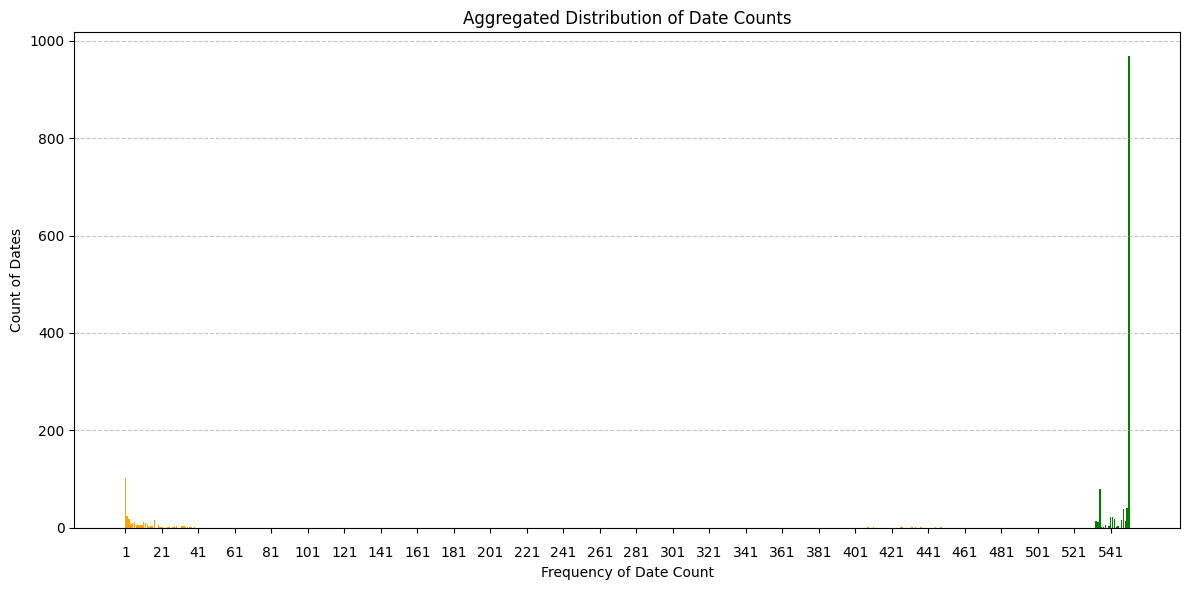

In [ ]:
plot_aggregated_date_distribution(date_occurrences)
#Companies may choose to close on certain days while other companies or the entire market is still trading due to special reason.
#Some company announce earning during after hours, when trade is not on.

In [ ]:
# Due to the join of technical and fundamental df, we will be removing the date
#for those below 300 since most of the market are not operating and replace those empty date points with the data from the day before.
# Initialize an empty set to store dates with frequency > 300
filtered_dates = set()

# Iterate through the date_occurrences dictionary
for date, count in date_occurrences.items():
    if count > 300:
        filtered_dates.add(date)

# Now, filtered_dates will contain all dates that have more than 300 occurrences
print("number of ative trading days", len(filtered_dates), filtered_dates)
print(len(date_occurrences))

number of ative trading days 1267 {Timestamp('2021-08-04 00:00:00'), Timestamp('2020-02-13 00:00:00'), Timestamp('2024-02-07 00:00:00'), Timestamp('2021-06-16 00:00:00'), Timestamp('2021-07-15 00:00:00'), Timestamp('2020-03-30 00:00:00'), Timestamp('2022-02-16 00:00:00'), Timestamp('2022-08-12 00:00:00'), Timestamp('2024-06-17 00:00:00'), Timestamp('2022-03-11 00:00:00'), Timestamp('2021-04-13 00:00:00'), Timestamp('2023-11-03 00:00:00'), Timestamp('2020-09-21 00:00:00'), Timestamp('2020-10-06 00:00:00'), Timestamp('2024-04-29 00:00:00'), Timestamp('2021-03-15 00:00:00'), Timestamp('2022-09-09 00:00:00'), Timestamp('2024-04-16 00:00:00'), Timestamp('2021-06-07 00:00:00'), Timestamp('2021-03-19 00:00:00'), Timestamp('2021-08-05 00:00:00'), Timestamp('2022-01-28 00:00:00'), Timestamp('2024-03-20 00:00:00'), Timestamp('2023-03-20 00:00:00'), Timestamp('2022-10-11 00:00:00'), Timestamp('2023-04-20 00:00:00'), Timestamp('2023-10-09 00:00:00'), Timestamp('2022-06-13 00:00:00'), Timestamp('20

In [ ]:
def add_missing_dates_to_tickers(ticker_data_dict, filtered_dates):
    """
    For each ticker in the dictionary, adds rows for dates that are not in the filtered_dates set,
    removes extra dates (dates in the DataFrame but not in filtered_dates), and forward fills NaN values.

    Parameters:
    ticker_data_dict (dict): Dictionary with tickers as keys and their respective DataFrames as values.
    filtered_dates (set): Set containing dates with frequency greater than 300.

    Returns:
    dict: Updated ticker_data_dict with rows added for missing dates and extra dates removed.
    """
    missing_date_list = []  # List to store missing data frames

    # Loop through each ticker and its DataFrame
    for ticker, df in ticker_data_dict.items():
        # Get the set of existing dates in the current DataFrame index
        existing_dates = set(df.index)

        # Get the missing dates (those in filtered_dates but not in the DataFrame index)
        missing_dates_set = filtered_dates - existing_dates
        missing_dates = list(missing_dates_set)

        # Get the extra dates (dates in the DataFrame but not in filtered_dates)
        extra_dates = list(existing_dates - filtered_dates)

        # Remove the extra dates from the DataFrame
        if extra_dates:
            df = df.drop(extra_dates)

        # If there are any missing dates, create rows for them
        if missing_dates:  # Check if there are missing dates
            # # Create a DataFrame for the missing dates (with NaN values for the columns)
            missing_data = pd.DataFrame(index=missing_dates, columns=df.columns )
            missing_date_list.append(missing_data)
            # Append the missing rows to the DataFrame
            df1 = pd.concat([df, missing_data], axis=0)
            df2 = df1.sort_index()
            # Alternately, this works too but just much slower
            # for date in missing_dates:
            #     df.loc[date] = [None] * len(df.columns)  # Add a row with NaN values

        else:
          df2 = df

        # Forward fill the NaN values with the value directly above it
        df3 = df2.ffill()
        # print(len(df3))

        # Update the ticker_data_dict with the cleaned DataFrame
        ticker_data_dict[ticker] = df3

    return ticker_data_dict, missing_date_list

<ipython-input-328-553746168dac>:37: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df1 = pd.concat([df, missing_data], axis=0)
<ipython-input-328-553746168dac>:37: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df1 = pd.concat([df, missing_data], axis=0)
<ipython-input-328-553746168dac>:37: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. T

[              P MA@20  RSI  CCI BB_upper BB_lower   GM epsdiluted   PE  GPG  ALR    L
2024-06-30  NaN   NaN  NaN  NaN      NaN      NaN  NaN        NaN  NaN  NaN  NaN  NaN
2019-03-31  NaN   NaN  NaN  NaN      NaN      NaN  NaN        NaN  NaN  NaN  NaN  NaN
2019-06-30  NaN   NaN  NaN  NaN      NaN      NaN  NaN        NaN  NaN  NaN  NaN  NaN
2019-09-30  NaN   NaN  NaN  NaN      NaN      NaN  NaN        NaN  NaN  NaN  NaN  NaN
2018-12-31  NaN   NaN  NaN  NaN      NaN      NaN  NaN        NaN  NaN  NaN  NaN  NaN
2023-12-31  NaN   NaN  NaN  NaN      NaN      NaN  NaN        NaN  NaN  NaN  NaN  NaN
2024-03-31  NaN   NaN  NaN  NaN      NaN      NaN  NaN        NaN  NaN  NaN  NaN  NaN,               P MA@20  RSI  CCI BB_upper BB_lower   GM epsdiluted   PE  GPG  ALR    L
2020-08-07  NaN   NaN  NaN  NaN      NaN      NaN  NaN        NaN  NaN  NaN  NaN  NaN
2020-02-13  NaN   NaN  NaN  NaN      NaN      NaN  NaN        NaN  NaN  NaN  NaN  NaN
2020-02-12  NaN   NaN  NaN  NaN      NaN      NaN  N

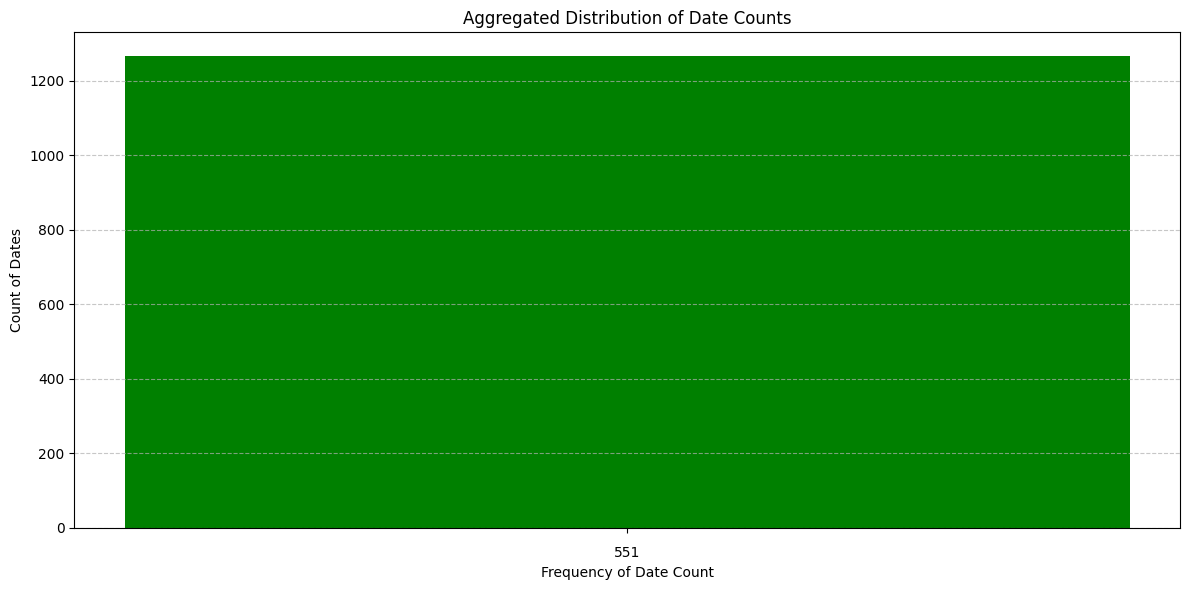

In [ ]:
# Update the ticker_data_dict with the missing rows added
sync_data_dictionary, missing_date_list= add_missing_dates_to_tickers(data_dictionary, filtered_dates)

print(missing_date_list)

_, sync_date_occurrences = process_tickers_data(sync_data_dictionary)

plot_aggregated_date_distribution(sync_date_occurrences)

In [ ]:
file_path = '/content/drive/MyDrive/Colab Notebooks/GNN/final_data.pkl'

# Open the file in write-binary mode and pickle the data
with open(file_path, 'wb') as f:
    pickle.dump(sync_data_dictionary, f)

print(f"Data successfully saved to {file_path}")

Data successfully saved to /content/drive/MyDrive/Colab Notebooks/GNN/Input_data/final_data.pkl


# Section 4: To Download News Data According to the Ticker List and Date in Previously Cleaned Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pickle
from sklearn.preprocessing import MinMaxScaler
import requests
import pandas as pd
from collections import defaultdict
import time
import datetime
import matplotlib.pyplot as plt
from random import choice


Mounted at /content/drive


In [ ]:
# Specify the path to your pickle file
file_path = '/content/drive/MyDrive/Colab Notebooks/GNN/final_data.pkl'

# Open the pickle file in read-binary mode
with open(file_path, 'rb') as f:
    loaded_data = pickle.load(f)


print(type(loaded_data))
print(len(loaded_data))

<class 'dict'>
551


In [ ]:
loaded_data['AAPL'].head(3)

,P,MA@20,RSI,CCI,BB_upper,BB_lower,GM,epsdiluted,PE,GPG,ALR,L
2018-12-31,72.88,77.2215,87.323944,63.118434,81.80731,72.63569,0.383548,1.25,58.304,0.0,1.356574,1.209548
2019-03-31,72.88,77.2215,87.323944,63.118434,81.80731,72.63569,0.383548,1.25,58.304,0.0,1.356574,1.209548
2019-06-30,72.88,77.2215,87.323944,63.118434,81.80731,72.63569,0.383548,1.25,58.304,0.0,1.356574,1.209548


In [ ]:
!pip install python-dotenv
from dotenv import load_dotenv
import os

path = "/content/drive/MyDrive/Colab Notebooks/GNN/.env"

load_dotenv(path)

# Access the loaded variables
api_key = os.getenv('ALPHA_API_KEY')
#Turns out FMT does not have enough news data in the before 2023, so I decided to subscribe to Alpha Vintage for more quality and abundant news data.

In [ ]:
# Initialize an empty list to store news data for all tickers
all_news_data = []

# Define the retry function
def fetch_news_with_retries(url, retries=3, delay=5):
    for attempt in range(retries):
        response = requests.get(url)
        if response.status_code == 200:
            return response.json()
        else:
            print(f"Attempt {attempt+1} failed: {response.status_code}")
            time.sleep(delay)  # Wait before retrying
    return None  # Return None after retries fail

# Fetch news for each ticker based on its DataFrame index
for ticker, df in loaded_data.items():
    start_date = df.index.min().strftime("%Y-%m-%d")
    end_date = df.index.max().strftime("%Y-%m-%d")

    url = f"{BASE_URL}?tickers={ticker}&from={start_date}&to={end_date}&apikey={API_KEY}"
    print(f"Fetching news for {ticker} from {start_date} to {end_date}...")

    ticker_news = fetch_news_with_retries(url)
    if ticker_news:
        # Add the ticker as a column to the news data
        for news_item in ticker_news:
            news_item["ticker"] = ticker  # Adding ticker symbol to each news item
        all_news_data.extend(ticker_news)  # Add news items to the list
    else:
        print(f"Failed to fetch news for {ticker} after retries.")

# Combine all news data into a single DataFrame
combined_news_df = pd.DataFrame(all_news_data)

# Optionally, check the first few rows of the DataFrame
print(combined_news_df.head())


Fetching news for AAL from 2018-12-31 to 2024-12-27...
Fetching news for AAON from 2018-12-31 to 2024-12-27...
Fetching news for AAPL from 2018-12-31 to 2024-12-27...
Fetching news for ABNB from 2018-12-31 to 2024-12-27...
Fetching news for ACAD from 2018-12-31 to 2024-12-27...
Fetching news for ACHC from 2018-12-31 to 2024-12-27...
Fetching news for ACIW from 2018-12-31 to 2024-12-27...
Fetching news for ACLS from 2018-12-31 to 2024-12-27...
Fetching news for ACTG from 2018-12-31 to 2024-12-27...
Fetching news for ADBE from 2018-12-31 to 2024-12-27...
Fetching news for ADI from 2018-12-31 to 2024-12-27...
Fetching news for ADP from 2018-12-31 to 2024-12-27...
Fetching news for ADPT from 2018-12-31 to 2024-12-27...
Fetching news for ADSK from 2018-12-31 to 2024-12-27...
Fetching news for ADTN from 2018-12-31 to 2024-12-27...
Fetching news for AEIS from 2018-12-31 to 2024-12-27...
Fetching news for AGIO from 2018-12-31 to 2024-12-27...
Fetching news for AGYS from 2018-12-31 to 2024-12-2

In [ ]:
# Process and print some of the data
for article in news_data[0:3]:  # Print first 5 articles
    print(f"Title: {article['title']}")
    print(f"Date: {article['time_published']}")
    print(f"Link: {article['url']}")
    print(f"Summary: {article['summary']}")
    print(f"Topics: {article['topics']}")
    print(f"Keys are: {article.keys()}")
    print("-" * 50)

Title: U.S. follows Canada, Europe on Russian aircraft ban
Date: 20220301T080000
Link: https://www.reuters.com/business/airspace-closures-after-ukraine-invasion-stretch-global-supply-chains-2022-03-01/
Summary: An AirBridgeCargo Airlines Boeing 747-87U arrives at Paris Charles de Gaulle airport in Roissy-en-France carrying 21-million face masks during the outbreak of the coronavirus disease  ( COVID-19 )  in France May 25, 2020. REUTERS/Charles Platiau
Topics: [{'topic': 'Energy & Transportation', 'relevance_score': '1.0'}]
Keys are: dict_keys(['title', 'url', 'time_published', 'authors', 'summary', 'banner_image', 'source', 'category_within_source', 'source_domain', 'topics', 'overall_sentiment_score', 'overall_sentiment_label', 'ticker_sentiment'])
--------------------------------------------------
Title: Airline Stocks Descend Amid Russia-Ukraine War
Date: 20220304T210800
Link: https://www.thestreet.com/investing/airline-stocks-descend-russia-ukraine-war
Summary: The main airline ET

In [ ]:
def fetch_news_with_tracking(ticker, start_date, end_date, api_key, limit=1000):
    results = []
    queue = [(start_date, end_date)]  # Queue of date ranges to process
    api_calls = 0  # Counter to track API calls within a minute
    total_news_count = 0  # Counter to track total news fetched for the ticker

    while queue:
        current_start_date, current_end_date = queue.pop(0)

        # Format the dates
        time_from = current_start_date.strftime("%Y%m%dT%H%M")
        time_to = current_end_date.strftime("%Y%m%dT%H%M")

        # Construct the API request
        url = (
            f"https://www.alphavantage.co/query?function=NEWS_SENTIMENT&tickers={ticker}&time_from={time_from}&time_to={time_to}&sort=EARLIEST&limit={limit}&apikey={api_key}"
        )


        # Make the API call
        response = requests.get(url)
        api_calls += 1
        data = response.json()

        # Check if the API call limit is about to be exceeded
        if api_calls >= 75:
            print("API call limit reached. Waiting for 1 minute...")
            time.sleep(60)  # Wait for 1 minute
            api_calls = 0  # Reset the counter

        # Add a delay between requests to stay within rate limits
        time.sleep(1)

        # If articles are returned, process them
        if "feed" in data:
            articles = data["feed"]
            results.extend(articles)
            total_news_count += len(articles)  # Update the news count

            # Print progress
            print(f"Fetched {len(articles)} news articles for {ticker}. Total so far: {total_news_count}.")

            # If exactly 50 articles are returned, split the range further
            if len(articles) == 50:
                mid_date = current_start_date + (current_end_date - current_start_date) / 2
                queue.append((current_start_date, mid_date))
                queue.append((mid_date, current_end_date))
        else:
            print(f"No articles found for range: {time_from} to {time_to}")

    # Convert results to a DataFrame
    df = pd.DataFrame(
        [{"time_published": article["time_published"], "title": article["title"], "summary": article["summary"]}
         for article in results]
    )

    print(f"Completed fetching news for {ticker}. Total news articles fetched: {total_news_count}.")
    return df


# Function to remove duplicates from news_dict
def process_news(news_dict):
    for ticker in news_dict:
        df = news_dict[ticker]
        news_dict[ticker] = df.drop_duplicates(subset=['time_published']).reset_index(drop=True)
    return news_dict

# Plot the news distribution for a randomly chosen ticker
def plot_news_distribution(news_dict):
    random_ticker = choice(list(news_dict.keys()))
    df = news_dict[random_ticker]

    # Convert time_published to datetime and extract date
    df['time_published'] = pd.to_datetime(df['time_published'])
    df['date'] = df['time_published'].dt.date

    # Count the number of news entries per date
    date_distribution = df['date'].value_counts().sort_index()

    # Plotting
    fig, ax = plt.subplots(figsize=(12, 6))
    date_distribution.plot(kind='bar', ax=ax)

    # Title and labels
    plt.title(f'Distribution of News Entries for {random_ticker}')
    plt.xlabel('Date')
    plt.ylabel('Number of News Entries')

    # Sparsely label the x-axis
    tick_positions = range(0, len(date_distribution), max(1, len(date_distribution) // 10))
    tick_labels = [date_distribution.index[i] for i in tick_positions]
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels, rotation=45)

    plt.show()


In [ ]:
# Main code
def execute_news_download(api_key=api_key, loaded_data=loaded_data):

    # Get the date range from the first ticker's DataFrame
    date_range = loaded_data[list(loaded_data.keys())[0]].index
    start_date, end_date = date_range[0], date_range[-1]

    # Fetch news for all tickers
    news_dict = {}
    for ticker in loaded_data.keys():
        print(f"Fetching news for {ticker}...")
        news_dict[ticker] = fetch_news_with_tracking(ticker, start_date, end_date, api_key)

    # Process the news dictionary to remove duplicates
    news_dict = process_news(news_dict)

    return news_dict

Fetching news for AAL...
Fetched 689 news articles for AAL. Total so far: 689.
Completed fetching news for AAL. Total news articles fetched: 689.
Fetching news for AAON...
Fetched 116 news articles for AAON. Total so far: 116.
Completed fetching news for AAON. Total news articles fetched: 116.
Fetching news for AAPL...
Fetched 685 news articles for AAPL. Total so far: 685.
Completed fetching news for AAPL. Total news articles fetched: 685.
Fetching news for ABNB...
Fetched 678 news articles for ABNB. Total so far: 678.
Completed fetching news for ABNB. Total news articles fetched: 678.
Fetching news for ACAD...
Fetched 430 news articles for ACAD. Total so far: 430.
Completed fetching news for ACAD. Total news articles fetched: 430.
Fetching news for ACHC...
Fetched 492 news articles for ACHC. Total so far: 492.
Completed fetching news for ACHC. Total news articles fetched: 492.
Fetching news for ACIW...
Fetched 158 news articles for ACIW. Total so far: 158.
Completed fetching news for 

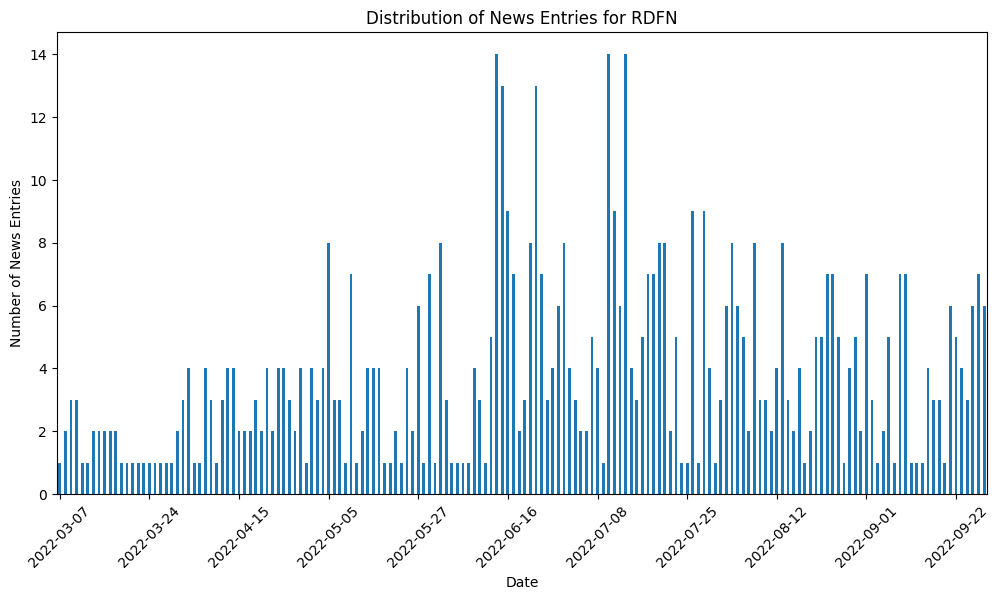

In [ ]:
news_dict = execute_news_download(api_key=api_key, loaded_data=loaded_data)

# Plot the news distribution for a randomly chosen ticker
plot_news_distribution(news_dict)

In [ ]:
pickle_file_path = "/content/drive/MyDrive/Colab Notebooks/GNN/news_dict.pkl"

In [ ]:
# Save news_dict to a pickle file
def save_news_dict(news_dict, file_path):
    with open(file_path, 'wb') as f:
        pickle.dump(news_dict, f)
    print(f"news_dict saved to {file_path}")

save_news_dict(news_dict, pickle_file_path)

news_dict saved to /content/drive/MyDrive/Colab Notebooks/GNN/news_dict.pkl


In [ ]:
# Load news_dict from a pickle file
def load_news_dict(file_path):
    with open(file_path, 'rb') as f:
        news_dict = pickle.load(f)
    print(f"news_dict loaded from {file_path}")
    return news_dict

loaded_news_dict = load_news_dict(pickle_file_path)

news_dict loaded from /content/drive/MyDrive/Colab Notebooks/GNN/news_dict.pkl


In [ ]:
# Load the Loughran-McDonald Master Dictionary
path = "/content/drive/MyDrive/Colab Notebooks/GNN/Loughran-McDonald_MasterDictionary_1993-2023.csv"
master_df = pd.read_csv(path)

# Initialize a dictionary of sets for the 7 sentiments
sentiment_sets = defaultdict(set)

# Columns to consider
sentiment_columns = ['Negative', 'Positive', 'Uncertainty', 'Litigious', 'Strong_Modal', 'Weak_Modal', 'Constraining']

# Filter out rows where the 'Word' column is NaN or not a string
master_df = master_df[master_df['Word'].notna()]  # Remove NaN values in 'Word'
master_df['Word'] = master_df['Word'].astype(str)  # Ensure all words are strings

# Populate the dictionary with sets of words
for _, row in master_df.iterrows():
    word = row['Word'].lower()
    for sentiment in sentiment_columns:
        if row[sentiment] > 0:  # Check if the sentiment value is greater than 0
            sentiment_sets[sentiment].add(word)

In [ ]:
print(loaded_news_dict["AAL"].head(3))
print(sentiment_sets['Positive'])

    time_published                                              title  \
0  20220301T080000  U.S. follows Canada, Europe on Russian aircraf...   
1  20220304T210800     Airline Stocks Descend Amid Russia-Ukraine War   
2  20220305T223733      The Best Time to Use Your Airline Miles? Now.   

                                             summary  \
0  An AirBridgeCargo Airlines Boeing 747-87U arri...   
1  The main airline ETF has slumped 16% since Feb...   
2  If you're thinking of traveling and you've got...   

                                                text  Negative  Uncertainty  \
0  U.S. follows Canada, Europe on Russian aircraf...       0.0         0.50   
1  Airline Stocks Descend Amid Russia-Ukraine War...       0.0         0.00   
2  The Best Time to Use Your Airline Miles? Now. ...       0.0         0.25   

   Constraining  Positive  Litigious  Weak_Modal  Strong_Modal        date  
0           0.0      0.00        0.0        0.50          0.00  2022-03-01  
1          

In [ ]:
print(len(loaded_news_dict))

551


In [ ]:
# Function to count sentiment words in 'text' column
def count_sentiment_words(text, sentiment_set):
    words = text.split()  # Split text into words
    return sum(1 for word in words if word.lower() in sentiment_set)  # Case-insensitive match


def process_news_sentiment(news_dict, sentiment_sets):
    processed_news_dict = {}  # Create a new dictionary for processed data

    for ticker, df in news_dict.items():
        # print(f"Handling {ticker} now")

        # Skip processing if the DataFrame is already empty
        if df.empty:
            print(f"Skipping empty DataFrame for ticker: {ticker}")
            processed_news_dict[ticker] = pd.DataFrame()  # Add empty DataFrame to new dict
            continue

        # Check if both 'title' and 'summary' columns are present
        if 'title' in df.columns and 'summary' in df.columns:
            # Concatenate title and summary into a new column 'text'
            df['text'] = df['title'] + ' ' + df['summary']
        elif 'text' in df.columns:
            # Rename the existing column to 'text' if it's already provided
            df.rename(columns={df.columns[0]: 'text'}, inplace=True)
        else:
            # If required columns are missing, make the DataFrame empty
            processed_news_dict[ticker] = pd.DataFrame()
            print(f"Missing required columns for ticker: {ticker}. Skipping...")
            continue

        # Add new columns for sentiment (with default 0 values)
        sentiment_columns = list(sentiment_sets.keys())
        for sentiment in sentiment_columns:
            df[sentiment] = 0

        # Process each row in the DataFrame
        for idx, row in df.iterrows():
            text = row['text']
            for sentiment in sentiment_columns:
                df.at[idx, sentiment] = count_sentiment_words(text, sentiment_sets[sentiment])

        # Normalize sentiment scores for each row (row-wise normalization)
        df[sentiment_columns] = df[sentiment_columns].div(
            df[sentiment_columns].sum(axis=1), axis=0
        ).fillna(0)

        # Convert time_published to date format
        if 'time_published' in df.columns:
            df['date'] = pd.to_datetime(df['time_published']).dt.date
        else:
            print(f"Missing 'time_published' column for ticker: {ticker}. Skipping...")
            processed_news_dict[ticker] = pd.DataFrame()
            continue

        # Group by 'date' and sum the sentiment columns
        df_grouped = df.groupby('date')[sentiment_columns].sum()

        # Normalize again after grouping (row-wise normalization)
        df_grouped = df_grouped.div(df_grouped.sum(axis=1), axis=0).fillna(0)

        # Set the index to 'date'
        df_grouped.reset_index(inplace=True)
        df_grouped.set_index('date', inplace=True)

        # Add the processed DataFrame to the new dictionary
        processed_news_dict[ticker] = df_grouped[sentiment_columns]

    return processed_news_dict

In [ ]:
# Example usage
processed_news_dict = process_news_sentiment(loaded_news_dict, sentiment_sets)

# Accessing the processed data
print(processed_news_dict['AAL'])

Skipping empty DataFrame for ticker: CHRD
Skipping empty DataFrame for ticker: CMCSA
Skipping empty DataFrame for ticker: COOP
Skipping empty DataFrame for ticker: FCNCA
Skipping empty DataFrame for ticker: FOXA
Skipping empty DataFrame for ticker: GOOGL
Skipping empty DataFrame for ticker: HAYN
Skipping empty DataFrame for ticker: HBAN
Skipping empty DataFrame for ticker: IEP
Skipping empty DataFrame for ticker: LBRDA
Skipping empty DataFrame for ticker: LYFT
Skipping empty DataFrame for ticker: MPWR
Skipping empty DataFrame for ticker: NBTB
Skipping empty DataFrame for ticker: NDAQ
Skipping empty DataFrame for ticker: NWS
Skipping empty DataFrame for ticker: NWSA
Skipping empty DataFrame for ticker: PTSI
Skipping empty DataFrame for ticker: RBBN
Skipping empty DataFrame for ticker: TROW
Skipping empty DataFrame for ticker: TW
Skipping empty DataFrame for ticker: ZG
            Negative  Uncertainty  Constraining  Positive  Litigious  \
date                                            

In [ ]:
def synchronize_and_process_news(news_ticker_dict, loaded_data, sentiment_columns):
    # Step 1: Get the set of dates to synchronize based on the first ticker in loaded_data
    first_ticker = next(iter(loaded_data))  # Get the first ticker key
    date_set = set(pd.to_datetime(loaded_data[first_ticker].index).strftime('%Y-%m-%d'))  # Extract dates in string format

    # Step 2: Process each ticker's DataFrame
    for ticker, news_ticker_df in news_ticker_dict.items():
        if news_ticker_df.empty:
            # Create an empty DataFrame with required sentiment columns and set 'date' as index
            news_ticker_df = pd.DataFrame(columns=sentiment_columns, index=pd.to_datetime(list(date_set)))
            news_ticker_df = news_ticker_df.fillna(0)  # Initialize all values with 0
        else:
            # Ensure the index is a datetime index
            news_ticker_df.index = pd.to_datetime(news_ticker_df.index)

        # Add missing dates with zero values for sentiment columns
        for date in date_set:
            if date not in news_ticker_df.index.strftime('%Y-%m-%d'):
                # Add a row with zero values for all sentiment columns
                new_row = {col: 0.0 for col in sentiment_columns}
                news_ticker_df.loc[pd.to_datetime(date)] = new_row

        # Sort by date
        news_ticker_df.sort_index(inplace=True)

        # Step 3: Handle rows with zero sentiment sums
        for i in range(1, len(news_ticker_df)):
            row_sum = news_ticker_df.iloc[i].sum()
            if row_sum == 0:
                # Replace with the previous row's sentiment values if the sum is non-zero
                prev_row_sum = news_ticker_df.iloc[i - 1].sum()
                if prev_row_sum != 0:
                    news_ticker_df.iloc[i] = news_ticker_df.iloc[i - 1]

        # Step 4: Filter rows to include only dates in date_set
        news_ticker_df = news_ticker_df[
            news_ticker_df.index.strftime('%Y-%m-%d').isin(date_set)
        ]

        # Update the dictionary with the processed DataFrame
        news_ticker_dict[ticker] = news_ticker_df
        print(f"Processed ticker {ticker}")

    return news_ticker_dict

In [ ]:
synchronized_news_dict = synchronize_and_process_news(processed_news_dict, loaded_data, sentiment_columns)

Processed ticker AAL
Processed ticker AAON
Processed ticker AAPL
Processed ticker ABNB
Processed ticker ACAD
Processed ticker ACHC
Processed ticker ACIW
Processed ticker ACLS
Processed ticker ACTG
Processed ticker ADBE
Processed ticker ADI
Processed ticker ADP
Processed ticker ADPT
Processed ticker ADSK
Processed ticker ADTN
Processed ticker AEIS
Processed ticker AGIO
Processed ticker AGYS
Processed ticker AKAM
Processed ticker ALGN
Processed ticker ALGT
Processed ticker ALNY
Processed ticker ALRM
Processed ticker ALTR
Processed ticker AMAT
Processed ticker AMBA
Processed ticker AMCX
Processed ticker AMED
Processed ticker AMGN
Processed ticker AMKR
Processed ticker AMSC
Processed ticker AMWD
Processed ticker AMZN
Processed ticker ANDE
Processed ticker ANGI
Processed ticker ANSS
Processed ticker APEI
Processed ticker APPF
Processed ticker APPN
Processed ticker ARCB
Processed ticker ARCC
Processed ticker AROW
Processed ticker ARWR
Processed ticker ASTS
Processed ticker ATNI
Processed tic

<ipython-input-65-0bb82d8ba613>:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  news_ticker_df = news_ticker_df.fillna(0)  # Initialize all values with 0


Processed ticker CHRD
Processed ticker CHRW
Processed ticker CHSCP
Processed ticker CHTR
Processed ticker CINF
Processed ticker CLFD
Processed ticker CLMT
Processed ticker CLOV


<ipython-input-65-0bb82d8ba613>:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  news_ticker_df = news_ticker_df.fillna(0)  # Initialize all values with 0


Processed ticker CMCSA
Processed ticker CME
Processed ticker CNXN
Processed ticker COKE
Processed ticker COLM
Processed ticker COMM


<ipython-input-65-0bb82d8ba613>:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  news_ticker_df = news_ticker_df.fillna(0)  # Initialize all values with 0


Processed ticker COOP
Processed ticker CORT
Processed ticker COST
Processed ticker CPRT
Processed ticker CPRX
Processed ticker CRAI
Processed ticker CROX
Processed ticker CRUS
Processed ticker CRVL
Processed ticker CRWD
Processed ticker CSCO
Processed ticker CSGP
Processed ticker CSX
Processed ticker CTAS
Processed ticker CTSH
Processed ticker CVGW
Processed ticker CVLT
Processed ticker CWBC
Processed ticker CWST
Processed ticker CYRX
Processed ticker CYTK
Processed ticker CZR
Processed ticker DAKT
Processed ticker DASH
Processed ticker DBX
Processed ticker DCOM
Processed ticker DDOG
Processed ticker DENN
Processed ticker DGII
Processed ticker DIOD
Processed ticker DJCO
Processed ticker DKNG
Processed ticker DLTR
Processed ticker DMRC
Processed ticker DOCU
Processed ticker DOMO
Processed ticker DXCM
Processed ticker EA
Processed ticker EBAY
Processed ticker EBC
Processed ticker ECPG
Processed ticker EEFT
Processed ticker EGBN
Processed ticker ENPH
Processed ticker ENTG
Processed ticker

<ipython-input-65-0bb82d8ba613>:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  news_ticker_df = news_ticker_df.fillna(0)  # Initialize all values with 0


Processed ticker FCNCA
Processed ticker FDBC
Processed ticker FFBC
Processed ticker FFIV
Processed ticker FHB
Processed ticker FIBK
Processed ticker FITB
Processed ticker FIVE
Processed ticker FIVN
Processed ticker FIZZ
Processed ticker FLGT
Processed ticker FLWS
Processed ticker FNKO
Processed ticker FOLD
Processed ticker FORR
Processed ticker FOX


<ipython-input-65-0bb82d8ba613>:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  news_ticker_df = news_ticker_df.fillna(0)  # Initialize all values with 0


Processed ticker FOXA
Processed ticker FOXF
Processed ticker FRME
Processed ticker FROG
Processed ticker FRPH
Processed ticker FRPT
Processed ticker FSLR
Processed ticker FTDR
Processed ticker FTNT
Processed ticker FULT
Processed ticker GDEN
Processed ticker GDRX
Processed ticker GERN
Processed ticker GEVO
Processed ticker GH
Processed ticker GILD
Processed ticker GLDD
Processed ticker GLPI
Processed ticker GNTX
Processed ticker GO
Processed ticker GOGO
Processed ticker GOOG


<ipython-input-65-0bb82d8ba613>:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  news_ticker_df = news_ticker_df.fillna(0)  # Initialize all values with 0


Processed ticker GOOGL
Processed ticker GPRE
Processed ticker GRPN
Processed ticker GT
Processed ticker HAFC
Processed ticker HAIN
Processed ticker HALO
Processed ticker HAS


<ipython-input-65-0bb82d8ba613>:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  news_ticker_df = news_ticker_df.fillna(0)  # Initialize all values with 0


Processed ticker HAYN


<ipython-input-65-0bb82d8ba613>:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  news_ticker_df = news_ticker_df.fillna(0)  # Initialize all values with 0


Processed ticker HBAN
Processed ticker HEAR
Processed ticker HLIT
Processed ticker HLNE
Processed ticker HOLX
Processed ticker HROW
Processed ticker HSIC
Processed ticker HSII
Processed ticker HTBI
Processed ticker HUBG
Processed ticker HURN
Processed ticker HWC
Processed ticker IAC
Processed ticker IBCP
Processed ticker IBKR
Processed ticker IBOC
Processed ticker ICFI
Processed ticker ICUI
Processed ticker IDCC
Processed ticker IDXX


<ipython-input-65-0bb82d8ba613>:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  news_ticker_df = news_ticker_df.fillna(0)  # Initialize all values with 0


Processed ticker IEP
Processed ticker IESC
Processed ticker IHRT
Processed ticker ILMN
Processed ticker IMKTA
Processed ticker INBK
Processed ticker INCY
Processed ticker INDB
Processed ticker INFN
Processed ticker INOD
Processed ticker INTC
Processed ticker INTU
Processed ticker IOSP
Processed ticker IOVA
Processed ticker IPGP
Processed ticker IRDM
Processed ticker IRWD
Processed ticker ISRG
Processed ticker ITRI
Processed ticker JACK
Processed ticker JAKK
Processed ticker JAMF
Processed ticker JBHT
Processed ticker JBLU
Processed ticker JJSF
Processed ticker JKHY
Processed ticker JOUT
Processed ticker KALU
Processed ticker KDP
Processed ticker KELYA
Processed ticker KHC
Processed ticker KLAC
Processed ticker KRUS
Processed ticker KTOS
Processed ticker KYMR
Processed ticker LAB
Processed ticker LAMR
Processed ticker LANC
Processed ticker LAUR
Processed ticker LAZR


<ipython-input-65-0bb82d8ba613>:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  news_ticker_df = news_ticker_df.fillna(0)  # Initialize all values with 0


Processed ticker LBRDA
Processed ticker LCID
Processed ticker LE
Processed ticker LECO
Processed ticker LEGN
Processed ticker LFUS
Processed ticker LGIH
Processed ticker LIN
Processed ticker LINC
Processed ticker LIND
Processed ticker LKQ
Processed ticker LNT
Processed ticker LOCO
Processed ticker LOGI
Processed ticker LOPE
Processed ticker LOVE
Processed ticker LPLA
Processed ticker LRCX
Processed ticker LSCC
Processed ticker LSTR
Processed ticker LWAY
Processed ticker LXRX


<ipython-input-65-0bb82d8ba613>:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  news_ticker_df = news_ticker_df.fillna(0)  # Initialize all values with 0


Processed ticker LYFT
Processed ticker MANH
Processed ticker MAR
Processed ticker MASI
Processed ticker MAT
Processed ticker MATW
Processed ticker MBUU
Processed ticker MCHP
Processed ticker MCRI
Processed ticker MDLZ
Processed ticker MEDP
Processed ticker META
Processed ticker MGEE
Processed ticker MIDD
Processed ticker MIRM
Processed ticker MKTX
Processed ticker MNKD
Processed ticker MNMD
Processed ticker MNRO
Processed ticker MNST
Processed ticker MOFG
Processed ticker MORN


<ipython-input-65-0bb82d8ba613>:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  news_ticker_df = news_ticker_df.fillna(0)  # Initialize all values with 0


Processed ticker MPWR
Processed ticker MRCY
Processed ticker MRNA
Processed ticker MRVL
Processed ticker MSEX
Processed ticker MSFT
Processed ticker MSTR
Processed ticker MTCH
Processed ticker MTSI
Processed ticker MU
Processed ticker MYGN
Processed ticker NATH
Processed ticker NAVI
Processed ticker NBIX
Processed ticker NBN


<ipython-input-65-0bb82d8ba613>:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  news_ticker_df = news_ticker_df.fillna(0)  # Initialize all values with 0


Processed ticker NBTB
Processed ticker NCMI


<ipython-input-65-0bb82d8ba613>:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  news_ticker_df = news_ticker_df.fillna(0)  # Initialize all values with 0


Processed ticker NDAQ
Processed ticker NDSN
Processed ticker NEO
Processed ticker NEOG
Processed ticker NFE
Processed ticker NFLX
Processed ticker NMRK
Processed ticker NSIT
Processed ticker NTAP
Processed ticker NTCT
Processed ticker NTGR
Processed ticker NTLA
Processed ticker NTNX
Processed ticker NTRA
Processed ticker NTRS
Processed ticker NVAX
Processed ticker NVDA
Processed ticker NWBI


<ipython-input-65-0bb82d8ba613>:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  news_ticker_df = news_ticker_df.fillna(0)  # Initialize all values with 0


Processed ticker NWS


<ipython-input-65-0bb82d8ba613>:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  news_ticker_df = news_ticker_df.fillna(0)  # Initialize all values with 0


Processed ticker NWSA
Processed ticker NXST
Processed ticker OCFC
Processed ticker ODFL
Processed ticker ODP
Processed ticker OKTA
Processed ticker OLED
Processed ticker OLLI
Processed ticker ON
Processed ticker ONB
Processed ticker OPEN
Processed ticker OPK
Processed ticker ORLY
Processed ticker OSIS
Processed ticker OSPN
Processed ticker OTTR
Processed ticker OZK
Processed ticker PACB
Processed ticker PANW
Processed ticker PARA
Processed ticker PAYX
Processed ticker PCAR
Processed ticker PCH
Processed ticker PCTY
Processed ticker PDCO
Processed ticker PDFS
Processed ticker PEGA
Processed ticker PENN
Processed ticker PFBC
Processed ticker PFG
Processed ticker PI
Processed ticker PLAB
Processed ticker PLAY
Processed ticker PLUG
Processed ticker PLUS
Processed ticker PLXS
Processed ticker PNFP
Processed ticker PODD
Processed ticker POWL
Processed ticker PPBI
Processed ticker PPC
Processed ticker PRAA
Processed ticker PRGS
Processed ticker PSMT
Processed ticker PTC
Processed ticker PTCT


<ipython-input-65-0bb82d8ba613>:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  news_ticker_df = news_ticker_df.fillna(0)  # Initialize all values with 0


Processed ticker PTSI
Processed ticker PYPL
Processed ticker PZZA
Processed ticker QCOM
Processed ticker QDEL
Processed ticker QLYS
Processed ticker QNST
Processed ticker QRVO


<ipython-input-65-0bb82d8ba613>:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  news_ticker_df = news_ticker_df.fillna(0)  # Initialize all values with 0


Processed ticker RBBN
Processed ticker RBCAA
Processed ticker RDFN
Processed ticker REAL
Processed ticker REGN
Processed ticker REYN
Processed ticker RGEN
Processed ticker RGLD
Processed ticker RICK
Processed ticker RMBS
Processed ticker RNA
Processed ticker ROAD
Processed ticker ROCK
Processed ticker ROKU
Processed ticker ROST
Processed ticker RPD
Processed ticker RUN
Processed ticker RUSHA
Processed ticker RYTM
Processed ticker SABR
Processed ticker SAIA
Processed ticker SANM
Processed ticker SASR
Processed ticker SATS
Processed ticker SBAC
Processed ticker SBGI
Processed ticker SBUX
Processed ticker SCHL
Processed ticker SCSC
Processed ticker SCVL
Processed ticker SEIC
Processed ticker SFIX
Processed ticker SFM
Processed ticker SFNC
Processed ticker SGMO
Processed ticker SIRI
Processed ticker SKYW
Processed ticker SLAB
Processed ticker SLM
Processed ticker SLP
Processed ticker SMCI
Processed ticker SMMT
Processed ticker SMTC
Processed ticker SNBR
Processed ticker SNEX
Processed tick

<ipython-input-65-0bb82d8ba613>:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  news_ticker_df = news_ticker_df.fillna(0)  # Initialize all values with 0


Processed ticker TROW
Processed ticker TRST
Processed ticker TRUE
Processed ticker TRUP
Processed ticker TSCO
Processed ticker TTD
Processed ticker TTEK
Processed ticker TTGT
Processed ticker TTWO


<ipython-input-65-0bb82d8ba613>:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  news_ticker_df = news_ticker_df.fillna(0)  # Initialize all values with 0


Processed ticker TW
Processed ticker TWST
Processed ticker TXG
Processed ticker TXN
Processed ticker TXRH
Processed ticker UAL
Processed ticker UBSI
Processed ticker UFPT
Processed ticker ULTA
Processed ticker UMBF
Processed ticker UPWK
Processed ticker URBN
Processed ticker VALU
Processed ticker VC
Processed ticker VCEL
Processed ticker VECO
Processed ticker VIAV
Processed ticker VICR
Processed ticker VIRT
Processed ticker VLGEA
Processed ticker VRNS
Processed ticker VRNT
Processed ticker VRSK
Processed ticker VRSN
Processed ticker VRTX
Processed ticker VSAT
Processed ticker VSEC
Processed ticker VTRS
Processed ticker WABC
Processed ticker WAFD
Processed ticker WBA
Processed ticker WBD
Processed ticker WDAY
Processed ticker WDC
Processed ticker WDFC
Processed ticker WEN
Processed ticker WERN
Processed ticker WINA
Processed ticker WING
Processed ticker WLDN
Processed ticker WMG
Processed ticker WOOF
Processed ticker WSBC
Processed ticker WSC
Processed ticker WSFS
Processed ticker WTFC


<ipython-input-65-0bb82d8ba613>:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  news_ticker_df = news_ticker_df.fillna(0)  # Initialize all values with 0


Processed ticker ZG
Processed ticker ZI
Processed ticker ZION
Processed ticker ZM
Processed ticker ZS
Processed ticker ZUMZ


In [ ]:
synchronized_news_dict['AAL'].tail(3)

,Negative,Uncertainty,Constraining,Positive,Litigious,Weak_Modal,Strong_Modal
date,,,,,,,
2024-12-24,0.5,0.0,0.0,0.0,0.0,0.0,0.5
2024-12-26,0.5,0.0,0.0,0.0,0.0,0.0,0.5
2024-12-27,0.5,0.0,0.0,0.0,0.0,0.0,0.5


In [ ]:
synchronized_news_file_path = "/content/drive/MyDrive/Colab Notebooks/GNN/synchronized_news_dict.pkl"
save_news_dict(synchronized_news_dict, synchronized_news_file_path)

news_dict saved to /content/drive/MyDrive/Colab Notebooks/GNN/synchronized_news_dict.pkl


In [ ]:
# Step 9: Verify date consistency
for ticker in loaded_data.keys():
    # Get the set of dates from loaded_data for the current ticker
    loaded_data_dates = set(loaded_data[ticker].index.strftime('%Y-%m-%d'))

    # Get the set of dates from synchronized_news_dict for the current ticker
    news_ticker_dates = set(synchronized_news_dict[ticker].index.strftime('%Y-%m-%d'))

    # Check if the sets match
    if loaded_data_dates != news_ticker_dates:
        print(f"Date mismatch for {ticker}!")
        print(f"Loaded Data Dates (size {len(loaded_data_dates)}): {loaded_data_dates}")
        print(f"News Ticker Dates (size {len(news_ticker_dates)}): {news_ticker_dates}")
    else:
        print(f"Dates match for {ticker}.")

# Step 10: Merging loaded_data with synchronized_news_dict
merged_dict = {}

for ticker in loaded_data.keys():
    # Merge the loaded_data (all columns) with the sentiment columns from synchronized_news_dict
    merged_df = loaded_data[ticker].merge(
        synchronized_news_dict[ticker][sentiment_columns],
        left_index=True,
        right_index=True,
        how='left'
    )

        # Replace NaN values in sentiment columns with 0
    merged_df[sentiment_columns] = merged_df[sentiment_columns].fillna(0)

    # Add the merged DataFrame to the dictionary
    merged_dict[ticker] = merged_df

Dates match for AAL.
Dates match for AAON.
Dates match for AAPL.
Dates match for ABNB.
Dates match for ACAD.
Dates match for ACHC.
Dates match for ACIW.
Dates match for ACLS.
Dates match for ACTG.
Dates match for ADBE.
Dates match for ADI.
Dates match for ADP.
Dates match for ADPT.
Dates match for ADSK.
Dates match for ADTN.
Dates match for AEIS.
Dates match for AGIO.
Dates match for AGYS.
Dates match for AKAM.
Dates match for ALGN.
Dates match for ALGT.
Dates match for ALNY.
Dates match for ALRM.
Dates match for ALTR.
Dates match for AMAT.
Dates match for AMBA.
Dates match for AMCX.
Dates match for AMED.
Dates match for AMGN.
Dates match for AMKR.
Dates match for AMSC.
Dates match for AMWD.
Dates match for AMZN.
Dates match for ANDE.
Dates match for ANGI.
Dates match for ANSS.
Dates match for APEI.
Dates match for APPF.
Dates match for APPN.
Dates match for ARCB.
Dates match for ARCC.
Dates match for AROW.
Dates match for ARWR.
Dates match for ASTS.
Dates match for ATNI.
Dates match f

In [ ]:
path = "/content/drive/MyDrive/Colab Notebooks/GNN/complete_df_price_tech_fun_news.pkl"
with open(path, 'wb') as f:
    pickle.dump(merged_dict, f)

# Section 5: Train, Validation, Test Split + Data Batching Based on Window Size

In [4]:
from google.colab import drive
drive.mount('/content/drive')
import pickle
from sklearn.preprocessing import MinMaxScaler
import pandas as pd


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Specify the path to your pickle file
file_path = "/content/drive/MyDrive/Colab Notebooks/GNN/complete_df_price_tech_fun_news.pkl"
# Open the pickle file in read-binary mode
with open(file_path, 'rb') as f:
    loaded_data = pickle.load(f)

print(type(loaded_data))
print(len(loaded_data))
print(loaded_data['AAL'].columns)

<class 'dict'>
551
Index(['P', 'MA@20', 'RSI', 'CCI', 'BB_upper', 'BB_lower', 'GM', 'epsdiluted',
       'PE', 'GPG', 'ALR', 'L', 'Negative', 'Positive', 'Uncertainty',
       'Litigious', 'Strong_Modal', 'Weak_Modal', 'Constraining'],
      dtype='object')


In [6]:
def check_indices_consistency_and_list_mismatches(data_dict):
    # Get the reference index as a set from the first DataFrame in the dictionary
    reference_index_set = None
    mismatched_tickers = []  # List to store tickers with index mismatches

    for key, df in data_dict.items():
        reference_index_set = set(df.index)  # Convert to a set for easy comparison
        print(f"The reference index for ticker {key} is of length {len(reference_index_set)}")
        break

    # Check the indices of all DataFrames against the reference index
    for key, df in data_dict.items():
        actual_index_set = set(df.index)  # Convert current DataFrame's index to a set

        # Compare indices
        extra_indices = actual_index_set - reference_index_set  # Indices present in actual but not in reference
        missing_indices = reference_index_set - actual_index_set  # Indices present in reference but not in actual

        if extra_indices or missing_indices:
            print(f"\nIndex mismatch found in DataFrame with key '{key}':")
            print(f"- Extra indices in '{key}': {sorted(extra_indices)}")
            print(f"- Missing indices in '{key}': {sorted(missing_indices)}")
            mismatched_tickers.append(key)

    # Print summary
    if not mismatched_tickers:
        print("\nAll DataFrames have consistent indices.")
    else:
        print("\nSummary of tickers with index mismatches:")
        for ticker in mismatched_tickers:
            print(f"- {ticker}")

    return mismatched_tickers  # Return the list of mismatched tickers

# Run the function
mismatched_tickers = check_indices_consistency_and_list_mismatches(loaded_data)


The reference index for ticker AAL is of length 1267

All DataFrames have consistent indices.


In [7]:
verification_look_up_dict = {key: i for i, (key, _) in enumerate(loaded_data.items())}


In [8]:
# Load the saved pickled file
path = '/content/drive/MyDrive/Colab Notebooks/GNN/'

with open(path + 'combined_adj_matrix.pkl', 'rb') as file:
    data_to_load = pickle.load(file)

# Display all the keys and data for inspection
for key, value in data_to_load.items():
    print(f"{key}: {type(value)}")

lookup_dict: <class 'dict'>
total_list_of_property: <class 'list'>
adj_matrices: <class 'dict'>


In [9]:
lookup_dict = data_to_load['lookup_dict']

In [10]:
#To verify again the orderly of the data against the look_up dict (To prevent miss alignment of the adjacency matrix in the future)
misaligned_list = []

for key, value in lookup_dict.items():
  if lookup_dict[key] != verification_look_up_dict[key]:
    misaligned_list.append(key)
    print(key)
    print(lookup_dict[key])
    print(verification_look_up_dict[key])

if not misaligned_list:
  print("No misalignment in the stock index")



No misalignment in the stock index


In [11]:
# Initialize counters for tickers with NaN or Infinity values
nan_tickers_count = 0
inf_tickers_count = 0
nan_ticker_list = []
inf_ticker_list = []

# Iterate through the tickers and check for NaN and Inf values
for ticker, df in loaded_data.items():
    # Check for NaN values
    if df.isnull().any().any():
        nan_tickers_count += 1
        print(f"Warning: NaN values found in ticker {ticker}")
        print(df.isnull().sum())  # To see the count of NaN values per column
        nan_ticker_list.append(ticker)

    # Check for Infinity values
    if (df == float('inf')).any().any() or (df == float('-inf')).any().any():
        inf_tickers_count += 1
        print(f"Warning: Infinity values found in ticker {ticker}")
        print(df[(df == float('inf')) | (df == float('-inf'))])  # Print rows with Inf values
        inf_ticker_list.append(ticker)

# After the loop, you can print the counts
print(f"Total tickers with NaN values: {nan_tickers_count}")
print(f"Total tickers with Infinity values: {inf_tickers_count}")
print(nan_ticker_list)
print(inf_ticker_list)

P                  0
MA@20              0
RSI                0
CCI                0
BB_upper           0
BB_lower           0
GM                 0
epsdiluted         0
PE              1267
GPG                0
ALR                0
L                  0
Negative           0
Positive           0
Uncertainty        0
Litigious          0
Strong_Modal       0
Weak_Modal         0
Constraining       0
dtype: int64
Total tickers with NaN values: 1
Total tickers with Infinity values: 0
['CHSCP']
[]


In [12]:
# Loop through all DataFrames in loaded_data and fill NaN values with 0
for ticker, df in loaded_data.items():
    loaded_data[ticker] = df.fillna(0)

# Verify the operation
print("NaN values have been filled with 0 in all DataFrames.")

NaN values have been filled with 0 in all DataFrames.


In [13]:
def train_val_test_split(data_dict, train_ratio=0.6, val_ratio=0.2, test_ratio=0.2):
    """
    Splits a dictionary of DataFrames into training, validation, and test dictionaries
    in chronological order.

    Parameters:
        data_dict (dict): A dictionary where keys are tickers and values are pandas DataFrames.
        train_ratio (float): Proportion of data for training.
        val_ratio (float): Proportion of data for validation.
        test_ratio (float): Proportion of data for testing.

    Returns:
        train_dict (dict): Training split dictionary.
        val_dict (dict): Validation split dictionary.
        test_dict (dict): Testing split dictionary.
    """
    train_dict = {}
    val_dict = {}
    test_dict = {}

    for ticker, df in data_dict.items():
        # Ensure the data is sorted by date or any chronological column
        df = df.sort_index()

        # Calculate split indices
        n = len(df)
        train_end = int(n * train_ratio)
        val_end = train_end + int(n * val_ratio)

        # Perform the splits
        train_dict[ticker] = df.iloc[:train_end]
        val_dict[ticker] = df.iloc[train_end:val_end]
        test_dict[ticker] = df.iloc[val_end:]

    return train_dict, val_dict, test_dict

In [14]:
train_dict, val_dict, test_dict = train_val_test_split(loaded_data)
print("Example: Length of df in each set: ", len(train_dict['AAPL']), len(val_dict['AAPL']), len(test_dict['AAPL']))

Example: Length of df in each set:  760 253 254


In [15]:
targeted_column = ['P', 'MA@20', 'RSI', 'CCI', 'BB_upper', 'BB_lower', 'GM', 'epsdiluted','PE', 'GPG', 'ALR', 'L']

# Section 6: To sample data using sliding window

In [16]:
import pandas as pd
import numpy as np

def transpose_3d_list(lists):
    return [[[lists[i][j][k] for k in range(len(lists[0][0]))]
             for i in range(len(lists))]
            for j in range(len(lists[0]))]

def transpose_2d_list(lists):
    return [[lists[j][i] for j in range(len(lists))]
            for i in range(len(lists[0]))]

def get_shape(nested_list):
    if isinstance(nested_list, list):
        return [len(nested_list)] + get_shape(nested_list[0])
    else:
        return []

def window_sampling(stock_data_dict, lookup_dict, window_size=20, step_size=10):
    stock_list = list(lookup_dict.keys())
    num_stocks = len(stock_list)

    # Initialize lists to store the results
    data_matrix = []
    return_rate_matrix = []
    ranking_matrix = []
    index_tracking = {'data_matrix': [], 'return_rate_matrix': []}

    for ticker in stock_list:
        df = stock_data_dict[ticker]

        # Ensure the DataFrame is sorted by date in ascending order
        if not df.index.is_monotonic_increasing:
            df = df.sort_index()

        # Extract the price data and other features
        prices = df['P'].values
        features = df.values

        # Initialize lists to store the batches for the current ticker
        ticker_data_batches = []
        ticker_return_batches = []
        ticker_index_batches = []

        # Loop through the data with the given window size and step size
        for i in range(0, len(prices) - window_size, step_size):
            if i + window_size + 1 >= len(prices):
                print(f"Skipping incomplete window for ticker {ticker} at position {i}")
                break

            window_data = features[i:i + window_size]
            next_day_price = prices[i + window_size]
            last_day_price = prices[i + window_size - 1]

            # Calculate the daily return rate, handle division by zero
            if last_day_price != 0:
                daily_return_rate = (next_day_price - last_day_price) / last_day_price
            else:
                daily_return_rate = 0  # or handle it in another way

            # Append the window data and return rate to the lists
            ticker_data_batches.append(window_data)
            ticker_return_batches.append(daily_return_rate)
            ticker_index_batches.append(df.index[i:i + window_size].tolist())

        # Append to the result lists
        data_matrix.append(ticker_data_batches)
        return_rate_matrix.append(ticker_return_batches)
        index_tracking['data_matrix'].append(ticker_index_batches)
        index_tracking['return_rate_matrix'].append(df.index[window_size::step_size].tolist())

    # Convert the lists to numpy arrays
    data_matrix = np.array(data_matrix)
    return_rate_matrix = np.array(return_rate_matrix)

    # Rearrange the dimensions
    data_matrix = np.transpose(data_matrix, (1, 0, 2, 3))
    return_rate_matrix = np.transpose(return_rate_matrix, (1, 0))



    return data_matrix, return_rate_matrix, index_tracking


In [17]:
def process_and_transpose_matrices(data_dict, lookup_dict):
    # Perform window sampling
    data_matrix, return_rate_matrix, index_tracking = window_sampling(data_dict, lookup_dict)

    # Print shapes of the matrices
    print("Shape of data_matrix:", data_matrix.shape)
    print("Shape of return_rate_matrix:", return_rate_matrix.shape)

    # Transpose the tracking matrices
    data_matrix_date = transpose_3d_list(index_tracking['data_matrix'])
    print("Shape of data_matrix date tracker:", get_shape(data_matrix_date))

    return_rate_matrix_date = transpose_2d_list(index_tracking['return_rate_matrix'])
    print("Shape of return_rate_matrix date tracker:", get_shape(return_rate_matrix_date))

    return data_matrix, return_rate_matrix, data_matrix_date, return_rate_matrix_date

In [18]:
train_data_matrix, train_return_rate_matrix, train_data_matrix_date, train_return_rate_matrix_date = process_and_transpose_matrices(train_dict, lookup_dict)

Shape of data_matrix: (74, 551, 20, 19)
Shape of return_rate_matrix: (74, 551)
Shape of data_matrix date tracker: [74, 551, 20]
Shape of return_rate_matrix date tracker: [74, 551]


In [19]:
val_data_matrix, val_return_rate_matrix, val_data_matrix_date, val_return_rate_matrix_date = process_and_transpose_matrices(val_dict, lookup_dict)

Shape of data_matrix: (24, 551, 20, 19)
Shape of return_rate_matrix: (24, 551)
Shape of data_matrix date tracker: [24, 551, 20]
Shape of return_rate_matrix date tracker: [24, 551]


In [20]:
test_data_matrix, test_return_rate_matrix, test_data_matrix_date, test_return_rate_matrix_date = process_and_transpose_matrices(test_dict, lookup_dict)

Shape of data_matrix: (24, 551, 20, 19)
Shape of return_rate_matrix: (24, 551)
Shape of data_matrix date tracker: [24, 551, 20]
Shape of return_rate_matrix date tracker: [24, 551]


In [21]:
first_df_columns = list(next(iter(train_dict.values())).columns)
feature_column_index = {k:i for i,k in enumerate(first_df_columns)}

In [22]:
feature_column_index['P']

0

# Section 7: To calculate the filter matrix using the DWT with Haar Wavelet Function.

In [23]:
import numpy as np
import subprocess
import sys

# Install pywt if not already installed
try:
    import pywt
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "PyWavelets"])
    import pywt

In [24]:
#Note: combined_tensor = tf.where(filter_tensor == 0, short_term, long_term)
#The output of the DWT function will be 0 for short term, 1 for long term.
import numpy as np
import pywt

def calculate_dwt_variances_for_price(data_matrix, price_column_index, option='median', custom_value=None):
    """
    Calculate DWT variances only for the price column in the data matrix.

    Args:
        data_matrix (np.ndarray): Input data with shape (batch_size, num_stocks, num_dates, num_features).
        price_column_index (int): The index of the price column to process.
        option (str): 'mean', 'median', 'Q1', 'Q3', or 'custom' to determine the threshold.
        custom_value (float): Custom threshold value if option is 'custom'.

    Returns:
        np.ndarray: Filter matrix of shape (batch_size, num_stocks).
    """
    # Initialize the output array
    batch_size, num_stocks, num_dates, num_features = data_matrix.shape
    variances = np.zeros((batch_size, num_stocks, 2))  # Shape (batch_size, num_stocks, 2)

    # Loop through each batch and each stock
    for b in range(batch_size):
        for s in range(num_stocks):
            # Extract the price data for the current stock
            price_data = data_matrix[b, s, :, price_column_index]  # Shape (num_dates,)

            # Apply DWT to the price data and calculate variances
            coeffs = pywt.dwt(price_data, 'haar')  # Using Haar wavelet
            cA, cD = coeffs  # Approximation and detail coefficients

            # Calculate variances
            variances[b, s, 0] = np.var(cA)  # Variance of low-pass filter
            variances[b, s, 1] = np.var(cD)  # Variance of high-pass filter

    # Calculate the option value (mean, median, Q1, Q3, or custom value)
    if option == 'mean':
        option_value = np.mean(variances[:, :, 1] - variances[:, :, 0])
    elif option == 'median':
        option_value = np.median(variances[:, :, 1] - variances[:, :, 0])
    elif option == 'Q1':
        option_value = np.percentile(variances[:, :, 1] - variances[:, :, 0], 25)
    elif option == 'Q3':
        option_value = np.percentile(variances[:, :, 1] - variances[:, :, 0], 75)
    elif option == 'custom' and custom_value is not None:
        option_value = custom_value
    else:
        raise ValueError("Option must be 'mean', 'median', 'Q1', 'Q3', or 'custom' with a specified custom_value")

    # Initialize the final output array
    filter_matrix = np.zeros((batch_size, num_stocks), dtype=int)  # Shape (batch_size, num_stocks)

    # Compare variances and apply the linear inequality
    for b in range(batch_size):
        for s in range(num_stocks):
            if variances[b, s, 1] - variances[b, s, 0] > option_value:
                filter_matrix[b, s] = 0
            else:
                filter_matrix[b, s] = 1

    # Calculate and print the percentage of zeros and median for each batch
    option_values = []
    zero_percentage_list = []
    for b in range(batch_size):
        zero_percentage = np.mean(filter_matrix[b, :] == 0) * 100
        zero_percentage_list.append(zero_percentage)

        if option == 'Q1':
            option_value = np.percentile(variances[b, :, 1] - variances[b, :, 0], 25)
        elif option == 'median':
            option_value = np.median(variances[b, :, 1] - variances[b, :, 0])
        elif option == 'Q3':
            option_value = np.percentile(variances[b, :, 1] - variances[b, :, 0], 75)
        else:
            raise ValueError("Option must be 'Q1', 'median', or 'Q3'")

        option_values.append(option_value)

    # Calculate and print the average of the option values across all batches
    average_option_value = np.mean(option_values)
    print(f"Average option value across all batches: {average_option_value:.4f}")

    # Calculate and print the average density of zeros across all batches
    average_density_of_zero = np.mean(zero_percentage_list)
    print(f"Average Density of Zero across all batches: {average_density_of_zero:.4f}%")

    return filter_matrix

In [25]:
#To output dictionaries
data_list = {"train": train_data_matrix, "val": val_data_matrix, "test": test_data_matrix}
options_list = ["Q1", "median", "Q3"]

def generate_filter_matrices(data_list, price_column_index, options_list):
    results = {
        'train': {},
        'val': {},
        'test': {}
    }

    for key, each_matrix in data_list.items():
        for option in options_list:
            print(f"Processing {key} data")
            print(f"Processing {option} mode")
            filter_matrix = calculate_dwt_variances_for_price(each_matrix, price_column_index, option=option)
            results[key][option] = filter_matrix

    return results['train'], results['val'], results['test']

In [ ]:
train_filter_martrix, val_filter_martrix, test_filter_martrix = generate_filter_matrices(data_list, feature_column_index['P'], options_list)

Processing train data
Processing Q1 mode
Average option value across all batches: -26.2777
Average Density of Zero across all batches: 74.9988%
Processing train data
Processing median mode
Average option value across all batches: -5.7353
Average Density of Zero across all batches: 50.0000%
Processing train data
Processing Q3 mode
Average option value across all batches: -1.2835
Average Density of Zero across all batches: 25.0012%
Processing val data
Processing Q1 mode
Average option value across all batches: -16.2535
Average Density of Zero across all batches: 75.0000%
Processing val data
Processing median mode
Average option value across all batches: -3.7373
Average Density of Zero across all batches: 50.0000%
Processing val data
Processing Q3 mode
Average option value across all batches: -0.7734
Average Density of Zero across all batches: 25.0000%
Processing test data
Processing Q1 mode
Average option value across all batches: -21.2239
Average Density of Zero across all batches: 75.0

Important note: If high pass- low pass is more -ve -> it is more volatile. ->likely be lower than threshold -> likely to be assigned 1

*  0 in filter_matrix: Indicates less volatile condition.
*   1 in filter_matrix: Indicates more volatile condition.
*   Q1 Mode: Results in a high percentage (around 75%) of stocks being classified as less volatile due to the strict threshold.
*   Median Mode: Results in a balanced classification with 50% of stocks being classified as less volatile.
*   Q3 Mode: Results in a lower percentage (around 25%) of stocks being classified as less volatile due to the lenient threshold.








In [26]:
import numpy as np
from scipy.stats import zscore
!pip install dtaidistance stumpy fastdtw
from dtaidistance import dtw
import stumpy
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
import time as tmod  # Import the time module with a different name to avoid conflict

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 50.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.5/176.5 kB 12.4 MB/s eta 0:00:00
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp311-cp311-linux_x86_64.whl size=542097 sha256=8297faa49fa90af5b39fae31a980305713835fb99326ef9775ea966fb960b306
  Stored in directory: /root/.cache/pip/wheels/5c/8a/f6/fd3df9a9714677410a5ccbf3ca519e66db4a54a1c46ea95332
Successfully built fastdtw


In [27]:
import numpy as np
import time
from scipy.spatial.distance import euclidean

def dtw_distance(ts_a, ts_b, window_size=2):
    """Compute the DTW distance between two time series with a window constraint."""

    # Reshape the time series to be column vectors (length, 1)
    ts_a = ts_a.reshape(-1, 1)
    ts_b = ts_b.reshape(-1, 1)

    # Define the window as the allowed path range
    max_shift = window_size

    # Initialize the DTW matrix
    dtw_matrix = np.full((len(ts_a), len(ts_b)), np.inf)
    dtw_matrix[0, 0] = 0

    # Start timing
    start_time = time.time()

    # Perform DTW with window constraint
    for i in range(1, len(ts_a)):
        for j in range(max(1, i - max_shift), min(len(ts_b), i + max_shift) + 1):
            # Ensure that index j does not exceed bounds
            if j < len(ts_b):
                cost = euclidean(ts_a[i], ts_b[j])
                # Take the minimum cost from the previous steps in the path
                dtw_matrix[i, j] = cost + min(dtw_matrix[i-1, j], dtw_matrix[i, j-1], dtw_matrix[i-1, j-1])

    # The final DTW distance is the value at the bottom-right of the matrix
    dtw_sim = dtw_matrix[len(ts_a) - 1, len(ts_b) - 1]

    # End timing
    end_time = time.time()
    computation_time = end_time - start_time

    return dtw_sim, computation_time

def safe_zscore(data, axis=1):
    """Compute zscore while handling constant rows (standard deviation is zero)."""
    std = np.std(data, axis=axis, keepdims=True)
    # Avoid division by zero by setting std = 1 where std is zero
    std[std == 0] = 1
    return (data - np.mean(data, axis=axis, keepdims=True)) / std

def mass_distance(ts_a, ts_b):
    """Compute the MASS (Mueen’s Algorithm for Similarity Search) distance between two time series."""
    m = len(ts_a)
    start_time = time.time()  # Start timing
    distance = stumpy.mass(ts_a, ts_b[:m])[0]  # Extract the single element
    end_time = time.time()  # End timing
    computation_time = end_time - start_time
    return distance, computation_time

def min_max_scale(matrix):
    """Scale the matrix values to the range [0, 1] using min-max scaling."""
    min_val = np.min(matrix)
    max_val = np.max(matrix)
    scaled_matrix = (matrix - min_val) / (max_val - min_val)
    return scaled_matrix

def normalize_matrix_rows(matrix):
    """Normalize the similarity matrix across both rows and columns after min-max scaling."""
    matrix = matrix.astype(np.float64)

    # Min-max scale the matrix
    scaled_matrix = min_max_scale(matrix)

    # Normalize the rows
    row_sums = scaled_matrix.sum(axis=1, keepdims=True)
    row_normalized_matrix = scaled_matrix / row_sums

    # Normalize the columns
    col_sums = row_normalized_matrix.sum(axis=0, keepdims=True)
    fully_normalized_matrix = row_normalized_matrix / col_sums
    return fully_normalized_matrix

def invert_and_normalize(matrix):
    """Invert the similarity scores and normalize again."""
    inverted_matrix = 1 - matrix
    return normalize_matrix_rows(inverted_matrix)

def pairwise_movement_similarity(ts_a, ts_b):
    """Compute the pairwise movement similarity between two time series."""
    start_time = time.time()  # Start timing
    movement_a = np.diff(ts_a) > 0  # Movement: True if increasing
    movement_b = np.diff(ts_b) > 0  # Movement: True if increasing
    similarity = np.mean(movement_a == movement_b)  # Compare movements
    end_time = time.time()  # End timing
    computation_time = end_time - start_time
    return similarity, computation_time

For DTW and Pairwiase Similiairty Only

In [28]:
def compute_similarity1(data_matrix, selected_feature_index=0):  # Feature_column_index['P'] = 0
    batch_size, num_stocks, num_time, num_features = data_matrix.shape

    similarity_dict = {
        # 'MASS long term': np.zeros((batch_size, num_stocks, num_stocks)),
        'DTW long term': np.zeros((batch_size, num_stocks, num_stocks)),
        'Pairwise movement long term': np.zeros((batch_size, num_stocks, num_stocks)),
        # 'MASS short term': np.zeros((batch_size, num_stocks, num_stocks)),
        'DTW short term': np.zeros((batch_size, num_stocks, num_stocks)),
        'Pairwise movement short term': np.zeros((batch_size, num_stocks, num_stocks))
    }

    # Initialize time tracking for each method
    time_tracker = {
        # 'MASS long term': [],
        'DTW long term': [],
        'Pairwise movement long term': [],
        # 'MASS short term': [],
        'DTW short term': [],
        'Pairwise movement short term': []
    }

    for b in range(batch_size):
        print(f"Handling batch number {b}")
        # Normalize the feature across the time dimension for long-term data
        normalized_data_long = safe_zscore(data_matrix[b, :, :, selected_feature_index], axis=1)

        if np.any(np.isnan(data_matrix[b, :, :, selected_feature_index])) or np.any(np.isinf(data_matrix[b, :, :, selected_feature_index])):
            print(f"NaN or Inf detected in input data for batch {b}")

        # Check for NaN or Inf after long-term normalization
        if np.any(np.isnan(normalized_data_long)) or np.any(np.isinf(normalized_data_long)):
            print(f"NaN or Inf detected in long-term normalized data for batch {b}")

        # Resample and normalize the short-term data (last 5 days)
        short_term_data = data_matrix[b, :, -5:, selected_feature_index]
        normalized_data_short = safe_zscore(short_term_data, axis=1)

        if np.any(np.isnan(data_matrix[b, :, -5, selected_feature_index])) or np.any(np.isinf(data_matrix[b, :, -5, selected_feature_index])):
            print(f"NaN or Inf detected in input data for batch {b}")

        # Check for NaN or Inf after short-term normalization
        if np.any(np.isnan(normalized_data_short)) or np.any(np.isinf(normalized_data_short)):
            print(f"NaN or Inf detected in short-term normalized data for batch {b}")

        for i in range(num_stocks):
            for j in range(num_stocks):
                ####################
                # Long-term similarity (whole sequence)
                # mass_sim_long, mass_time = mass_distance(normalized_data_long[i], normalized_data_long[j])
                dtw_sim_long, dtw_time = dtw_distance(normalized_data_long[i], normalized_data_long[j])

                # similarity_dict['MASS long term'][b, i, j] = mass_sim_long
                similarity_dict['DTW long term'][b, i, j] = dtw_sim_long
                # time_tracker['MASS long term'].append(mass_time)
                time_tracker['DTW long term'].append(dtw_time)

                # Pairwise movement similarity (long term)
                pairwise_sim_long, pairwise_time = pairwise_movement_similarity(normalized_data_long[i], normalized_data_long[j])
                similarity_dict['Pairwise movement long term'][b, i, j] = pairwise_sim_long
                time_tracker['Pairwise movement long term'].append(pairwise_time)

                #######################
                # Short-term similarity (last 5 days)
                # mass_sim_short, mass_time = mass_distance(normalized_data_short[i], normalized_data_short[j])
                dtw_sim_short, dtw_time = dtw_distance(normalized_data_short[i], normalized_data_short[j])

                # similarity_dict['MASS short term'][b, i, j] = mass_sim_short
                similarity_dict['DTW short term'][b, i, j] = dtw_sim_short
                # time_tracker['MASS short term'].append(mass_time)
                time_tracker['DTW short term'].append(dtw_time)

                # Pairwise movement similarity (short term)
                pairwise_sim_short, pairwise_time = pairwise_movement_similarity(normalized_data_short[i], normalized_data_short[j])
                similarity_dict['Pairwise movement short term'][b, i, j] = pairwise_sim_short
                time_tracker['Pairwise movement short term'].append(pairwise_time)

        # Normalize the similarity matrices across rows only
        for key in similarity_dict:
            print(f'Normalizing {key} on the batch number {b} ')
            similarity_dict[key][b] = normalize_matrix_rows(similarity_dict[key][b])

        # Invert and normalize only for MASS and DTW similarity scores
        for key in similarity_dict:
            if 'Pairwise movement long term' != key and 'Pairwise movement short term' != key:
                similarity_dict[key][b] = invert_and_normalize(similarity_dict[key][b])

    # Calculate sum time for each method
    sum_time_tracker = {key: np.sum(time_tracker[key]) for key in time_tracker}

    # Print the sum computation time for each method
    for key, sum_time in sum_time_tracker.items():
        print(f"Sum computation time for {key}: {sum_time:.8f} seconds")

    return similarity_dict, sum_time_tracker


Since the run time is too long, MASS is done separately.

In [29]:
def compute_similarity2(data_matrix, selected_feature_index=0):  # Feature_column_index['P'] = 0
    batch_size, num_stocks, num_time, num_features = data_matrix.shape

    similarity_dict = {
        'MASS long term': np.zeros((batch_size, num_stocks, num_stocks)),
        'MASS short term': np.zeros((batch_size, num_stocks, num_stocks))
    }

    # Initialize time tracking for each method
    time_tracker = {
        'MASS long term': [],
        'MASS short term': []
    }

    for b in range(batch_size):
        print(f"Handling batch number {b}")
        # Normalize the feature across the time dimension for long-term data
        normalized_data_long = safe_zscore(data_matrix[b, :, :, selected_feature_index], axis=1)

        if np.any(np.isnan(data_matrix[b, :, :, selected_feature_index])) or np.any(np.isinf(data_matrix[b, :, :, selected_feature_index])):
            print(f"NaN or Inf detected in input data for batch {b}")

        # Check for NaN or Inf after long-term normalization
        if np.any(np.isnan(normalized_data_long)) or np.any(np.isinf(normalized_data_long)):
            print(f"NaN or Inf detected in long-term normalized data for batch {b}")

        # Resample and normalize the short-term data (last 5 days)
        short_term_data = data_matrix[b, :, -5:, selected_feature_index]
        normalized_data_short = safe_zscore(short_term_data, axis=1)

        if np.any(np.isnan(data_matrix[b, :, -5, selected_feature_index])) or np.any(np.isinf(data_matrix[b, :, -5, selected_feature_index])):
            print(f"NaN or Inf detected in input data for batch {b}")

        # Check for NaN or Inf after short-term normalization
        if np.any(np.isnan(normalized_data_short)) or np.any(np.isinf(normalized_data_short)):
            print(f"NaN or Inf detected in short-term normalized data for batch {b}")

        for i in range(num_stocks):
            for j in range(num_stocks):
                ####################
                # Long-term similarity (whole sequence)
                mass_sim_long, mass_time = mass_distance(normalized_data_long[i], normalized_data_long[j])

                similarity_dict['MASS long term'][b, i, j] = mass_sim_long
                time_tracker['MASS long term'].append(mass_time)

                #######################
                # Short-term similarity (last 5 days)
                mass_sim_short, mass_time = mass_distance(normalized_data_short[i], normalized_data_short[j])
                similarity_dict['MASS short term'][b, i, j] = mass_sim_short
                time_tracker['MASS short term'].append(mass_time)


        # Normalize the similarity matrices across rows only
        for key in similarity_dict:
            print(f'Normalizing {key} on the batch number {b} ')
            similarity_dict[key][b] = normalize_matrix_rows(similarity_dict[key][b])

        # Invert and normalize only for MASS and DTW similarity scores
        for key in similarity_dict:
            if 'Pairwise movement long term' != key and 'Pairwise movement short term' != key:
                similarity_dict[key][b] = invert_and_normalize(similarity_dict[key][b])

    # Calculate sum time for each method
    sum_time_tracker = {key: np.sum(time_tracker[key]) for key in time_tracker}

    # Print the sum computation time for each method
    for key, sum_time in sum_time_tracker.items():
        print(f"Sum computation time for {key}: {sum_time:.8f} seconds")

    return similarity_dict, sum_time_tracker

In [ ]:
##Troubleshooting steps

import numpy as np
import time as tmod  # Import the time module with a different name to avoid conflict

# Mock data matrix with 4 stocks: sine, cosine, and linear increasing and decreasing values
batch_size = 1
num_stocks = 10
num_time = 20
num_features = 12

# Initialize data_matrix
data_matrix = np.zeros((batch_size, num_stocks, num_time, num_features))
data_matrix = val_data_matrix[:1,:,:,:]

# Generate sine and cosine functions
time_points = np.linspace(0, 2 * np.pi, num_time)  # Time points for sine and cosine
# Generate sine and cosine waves
sine_wave = np.sin(time_points)
cosine_wave = np.cos(time_points + 0.5 * np.pi)  # Apply a phase shift of 1/2pi to cosine

# Assign sine and cosine to the first two stocks
for b in range(batch_size):
    for f in range(num_features):
        data_matrix[b, 0, :, f] = sine_wave  # Stock 1: Sine
        data_matrix[b, 1, :, f] = cosine_wave  # Stock 2: Cosine

# Generate linear increasing and decreasing values for the 3rd and 4th stocks
for b in range(batch_size):
    for f in range(num_features):
        # Stock 3: Linearly increasing values
        data_matrix[b, 2, :, f] = np.linspace(0, 1, num_time)  # Linear increase
        # Stock 4: Linearly decreasing values
        data_matrix[b, 3, :, f] = np.linspace(1, 0, num_time)  # Linear decrease

# Compute similarity matrices (assuming compute_similarity function is defined)
similarity_dict, avg_time_tracker = compute_similarity1(data_matrix)
similarity_dict2, avg_time_tracker2 = compute_similarity2(data_matrix)

# Print results for Batch 0
# print(similarity_dict)
print("DTW Long Term Similarity Matrix for Batch 0:")
print(similarity_dict['DTW long term'][0])
print("Mass Long Term Similarity Matrix for Batch 0:")
print(similarity_dict2['MASS long term'][0])
print("Pairwise Movement Long Term Similarity Matrix for Batch 0:")
print(similarity_dict['Pairwise movement long term'][0])


print("DTW Short Term Similarity Matrix for Batch 0:")
print(similarity_dict['DTW short term'][0])
print("Mass short Term Similarity Matrix for Batch 0:")
print(similarity_dict2['MASS short term'][0])
print("Pairwise Movement Short Term Similarity Matrix for Batch 0:")
print(similarity_dict['Pairwise movement short term'][0])


Handling batch number 0
Normalizing MASS long term on the batch number 0 
Normalizing MASS short term on the batch number 0 
Sum computation time for MASS long term: 337.79018378 seconds
Sum computation time for MASS short term: 336.91944909 seconds
Mass Long Term Similarity Matrix for Batch 0:
[[0.00497365 0.00142831 0.0006641  ... 0.00224402 0.00228608 0.00076544]
 [0.00138774 0.00432311 0.0019242  ... 0.0012565  0.00213443 0.00113617]
 [0.00093085 0.00181025 0.00409536 ... 0.00115231 0.00179617 0.00236902]
 ...
 [0.0020266  0.00126148 0.00111776 ... 0.00444149 0.00172327 0.00198247]
 [0.00204735 0.00220871 0.00196065 ... 0.00171213 0.00445447 0.00120945]
 [0.00098691 0.00116518 0.00240075 ... 0.00181944 0.00123341 0.00410521]]
Mass short Term Similarity Matrix for Batch 0:
[[0.00432857 0.00062964 0.00391036 ... 0.00139561 0.00167291 0.00306432]
 [0.00040722 0.00477571 0.00031068 ... 0.00152438 0.00083034 0.00046752]
 [0.0038745  0.00057004 0.00431183 ... 0.0012512  0.00176942 0.0030

In [ ]:
import pickle

#For reference only: data_list = {"train": train_data_matrix, "val": val_data_matrix, "test": test_data_matrix}
print(f"Computing similarity for val dataset...")
adj_matrices, avg_time_tracker = compute_similarity1(val_data_matrix)
val_dynamic_adj_matrices = {'adj_matrices': adj_matrices,'avg_time_tracker': avg_time_tracker}
validation_data = [val_data_matrix, val_return_rate_matrix, val_data_matrix_date, val_return_rate_matrix_date, val_filter_martrix, val_dynamic_adj_matrices, feature_column_index]

# Save to a pickle file
with open('/content/drive/MyDrive/Colab Notebooks/GNN/Input_data/final_preprocessed_val_data1.pkl', 'wb') as file:
    pickle.dump(validation_data, file)
print("Data has been saved to final_preprocessed_data.pkl")

Computing similarity for val dataset...
Handling batch number 0
Normalizing DTW long term on the batch number 0 
Normalizing Pairwise movement long term on the batch number 0 
Normalizing DTW short term on the batch number 0 
Normalizing Pairwise movement short term on the batch number 0 
Handling batch number 1
Normalizing DTW long term on the batch number 1 
Normalizing Pairwise movement long term on the batch number 1 
Normalizing DTW short term on the batch number 1 
Normalizing Pairwise movement short term on the batch number 1 
Handling batch number 2
Normalizing DTW long term on the batch number 2 
Normalizing Pairwise movement long term on the batch number 2 
Normalizing DTW short term on the batch number 2 
Normalizing Pairwise movement short term on the batch number 2 
Handling batch number 3
Normalizing DTW long term on the batch number 3 
Normalizing Pairwise movement long term on the batch number 3 
Normalizing DTW short term on the batch number 3 
Normalizing Pairwise mov

In [ ]:
print(f"Computing similarity for test dataset...")
adj_matrices, avg_time_tracker = compute_similarity1(test_data_matrix)
test_dynamic_adj_matrices = {'adj_matrices': adj_matrices,'avg_time_tracker': avg_time_tracker}
test_data = [test_data_matrix, test_return_rate_matrix, test_data_matrix_date, test_return_rate_matrix_date, test_filter_martrix, test_dynamic_adj_matrices, feature_column_index]

# Save to a pickle file
with open('/content/drive/MyDrive/Colab Notebooks/GNN/Input_data/final_preprocessed_test_data1.pkl', 'wb') as file:
    pickle.dump(test_data, file)
print("Data has been saved to final_preprocessed_test_data1.pkl")

Computing similarity for test dataset...
Handling batch number 0
Normalizing DTW long term on the batch number 0 
Normalizing Pairwise movement long term on the batch number 0 
Normalizing DTW short term on the batch number 0 
Normalizing Pairwise movement short term on the batch number 0 
Handling batch number 1
Normalizing DTW long term on the batch number 1 
Normalizing Pairwise movement long term on the batch number 1 
Normalizing DTW short term on the batch number 1 
Normalizing Pairwise movement short term on the batch number 1 
Handling batch number 2
Normalizing DTW long term on the batch number 2 
Normalizing Pairwise movement long term on the batch number 2 
Normalizing DTW short term on the batch number 2 
Normalizing Pairwise movement short term on the batch number 2 
Handling batch number 3
Normalizing DTW long term on the batch number 3 
Normalizing Pairwise movement long term on the batch number 3 
Normalizing DTW short term on the batch number 3 
Normalizing Pairwise mo

In [ ]:
import pickle

print(f"Computing similarity for train dataset...")
adj_matrices, avg_time_tracker = compute_similarity1(train_data_matrix)
train_dynamic_adj_matrices = {'adj_matrices': adj_matrices,'avg_time_tracker': avg_time_tracker}
train_data = [train_data_matrix, train_return_rate_matrix, train_data_matrix_date, train_return_rate_matrix_date, train_filter_martrix, train_dynamic_adj_matrices, feature_column_index]

# Save to a pickle file
with open('/content/drive/MyDrive/Colab Notebooks/GNN/Input_data/final_preprocessed_train_data1.pkl', 'wb') as file:
    pickle.dump(train_data, file)
print("Data has been saved to final_preprocessed_data.pkl")

Computing similarity for train dataset...
Handling batch number 0
Normalizing DTW long term on the batch number 0 
Normalizing Pairwise movement long term on the batch number 0 
Normalizing DTW short term on the batch number 0 
Normalizing Pairwise movement short term on the batch number 0 
Handling batch number 1
Normalizing DTW long term on the batch number 1 
Normalizing Pairwise movement long term on the batch number 1 
Normalizing DTW short term on the batch number 1 
Normalizing Pairwise movement short term on the batch number 1 
Handling batch number 2
Normalizing DTW long term on the batch number 2 
Normalizing Pairwise movement long term on the batch number 2 
Normalizing DTW short term on the batch number 2 
Normalizing Pairwise movement short term on the batch number 2 
Handling batch number 3
Normalizing DTW long term on the batch number 3 
Normalizing Pairwise movement long term on the batch number 3 
Normalizing DTW short term on the batch number 3 
Normalizing Pairwise m

In [ ]:
import pickle

#For reference only: data_list = {"train": train_data_matrix, "val": val_data_matrix, "test": test_data_matrix}
print(f"Computing similarity for val dataset...")
adj_matrices, avg_time_tracker = compute_similarity2(val_data_matrix)
val_dynamic_adj_matrices = {'adj_matrices': adj_matrices,'avg_time_tracker': avg_time_tracker}
validation_data = [val_data_matrix, val_return_rate_matrix, val_data_matrix_date, val_return_rate_matrix_date, val_filter_martrix, val_dynamic_adj_matrices, feature_column_index]

# Save to a pickle file
with open('/content/drive/MyDrive/Colab Notebooks/GNN/Input_data/final_preprocessed_val_data2.pkl', 'wb') as file:
    pickle.dump(validation_data, file)
print("Data has been saved to final_preprocessed_data.pkl")

Computing similarity for val dataset...
Handling batch number 0
Normalizing MASS long term on the batch number 0 
Normalizing MASS short term on the batch number 0 
Handling batch number 1
Normalizing MASS long term on the batch number 1 
Normalizing MASS short term on the batch number 1 
Handling batch number 2
Normalizing MASS long term on the batch number 2 
Normalizing MASS short term on the batch number 2 
Handling batch number 3
Normalizing MASS long term on the batch number 3 
Normalizing MASS short term on the batch number 3 
Handling batch number 4
Normalizing MASS long term on the batch number 4 
Normalizing MASS short term on the batch number 4 
Handling batch number 5
Normalizing MASS long term on the batch number 5 
Normalizing MASS short term on the batch number 5 
Handling batch number 6
Normalizing MASS long term on the batch number 6 
Normalizing MASS short term on the batch number 6 
Handling batch number 7
Normalizing MASS long term on the batch number 7 
Normalizing

In [ ]:
print(f"Computing similarity for test dataset...")
adj_matrices, avg_time_tracker = compute_similarity2(test_data_matrix)
test_dynamic_adj_matrices = {'adj_matrices': adj_matrices,'avg_time_tracker': avg_time_tracker}
test_data = [test_data_matrix, test_return_rate_matrix, test_data_matrix_date, test_return_rate_matrix_date, test_filter_martrix, test_dynamic_adj_matrices, feature_column_index]

# Save to a pickle file
with open('/content/drive/MyDrive/Colab Notebooks/GNN/Input_data/final_preprocessed_test_data2.pkl', 'wb') as file:
    pickle.dump(test_data, file)
print("Data has been saved to final_preprocessed_data.pkl")

Computing similarity for test dataset...
Handling batch number 0
Normalizing MASS long term on the batch number 0 
Normalizing MASS short term on the batch number 0 
Handling batch number 1
Normalizing MASS long term on the batch number 1 
Normalizing MASS short term on the batch number 1 
Handling batch number 2
Normalizing MASS long term on the batch number 2 
Normalizing MASS short term on the batch number 2 
Handling batch number 3
Normalizing MASS long term on the batch number 3 
Normalizing MASS short term on the batch number 3 
Handling batch number 4
Normalizing MASS long term on the batch number 4 
Normalizing MASS short term on the batch number 4 
Handling batch number 5
Normalizing MASS long term on the batch number 5 
Normalizing MASS short term on the batch number 5 
Handling batch number 6
Normalizing MASS long term on the batch number 6 
Normalizing MASS short term on the batch number 6 
Handling batch number 7
Normalizing MASS long term on the batch number 7 
Normalizin

In [ ]:
import pickle

print(f"Computing similarity for train dataset...")
adj_matrices, avg_time_tracker = compute_similarity2(train_data_matrix)
train_dynamic_adj_matrices = {'adj_matrices': adj_matrices,'avg_time_tracker': avg_time_tracker}
train_data = [train_data_matrix, train_return_rate_matrix, train_data_matrix_date, train_return_rate_matrix_date, train_filter_martrix, train_dynamic_adj_matrices, feature_column_index]

# Save to a pickle file
with open('/content/drive/MyDrive/Colab Notebooks/GNN/Input_data/final_preprocessed_train_data2.pkl', 'wb') as file:
    pickle.dump(train_data, file)
print("Data has been saved to final_preprocessed_data.pkl")

Computing similarity for train dataset...
Handling batch number 0
Normalizing MASS long term on the batch number 0 
Normalizing MASS short term on the batch number 0 
Handling batch number 1
Normalizing MASS long term on the batch number 1 
Normalizing MASS short term on the batch number 1 
Handling batch number 2
Normalizing MASS long term on the batch number 2 
Normalizing MASS short term on the batch number 2 
Handling batch number 3
Normalizing MASS long term on the batch number 3 
Normalizing MASS short term on the batch number 3 
Handling batch number 4
Normalizing MASS long term on the batch number 4 
Normalizing MASS short term on the batch number 4 
Handling batch number 5
Normalizing MASS long term on the batch number 5 
Normalizing MASS short term on the batch number 5 
Handling batch number 6
Normalizing MASS long term on the batch number 6 
Normalizing MASS short term on the batch number 6 
Handling batch number 7
Normalizing MASS long term on the batch number 7 
Normalizi

NameError: name 'train_filter_martrix' is not defined

#House keeping: To combine the input data back again\

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pickle
Data_list = ['train', 'val', 'test']

In [ ]:

# Load the pickled data
for item in Data_list:
    file_path1 = f'/content/drive/MyDrive/Colab Notebooks/GNN/Input_data/final_preprocessed_{item}_data1.pkl'
    with open(file_path1, 'rb') as file:
        data1 = pickle.load(file)
    print(f"{item} data has been loaded from {file_path1}")

    file_path2 = f'/content/drive/MyDrive/Colab Notebooks/GNN/Input_data/final_preprocessed_{item}_data2.pkl'
    with open(file_path2, 'rb') as file:
        data2 = pickle.load(file)
    print(f"{item} data has been loaded from {file_path2}")

    # data1[5]['adj_matrices']['MASS long term'] = data2[5]['adj_matrices']['MASS long term']
    # data1[5]['adj_matrices']['MASS short term'] = data2[5]['avg_time_tracker']['MASS short term']
    # data1[5]['avg_time_tracker']['MASS long term'] = data2[5]['adj_matrices']['MASS long term']
    # data1[5]['avg_time_tracker']['MASS short term'] = data2[5]['avg_time_tracker']['MASS short term']

    for key, subdict in data2[5].items():
        if key in data1[5]:
            for subkey, value in subdict.items():
                data1[5][key][subkey] = value
                print(key)
                print(subkey)

    # To verify dictionary update
    for k, v in data1[5].items():
        print(f'\n Dict key is {k} with the nested key as')
        for kk, vv in v.items():
          print(f'{kk}')

    file_path3 = f'/content/drive/MyDrive/Colab Notebooks/GNN/Input_data/final_preprocessed_{item}_complete.pkl'
    with open(file_path3, 'wb') as file:
        pickle.dump(data1, file)
    print(f"Data has been saved to {file_path3}\n\n")